In [2]:
! pip install --upgrade jax jaxlib
! pip install pmdarima
! pip install statsmodels
! pip install tensorflow
! pip install keras
! pip install scikit-optimize
! pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 MB 6.0 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.4.14-py3-none-any.whl size=1535361 sha256=4b71060787333c61851c26cf6a26cef94c8a40e6f45fbe32c77cd98c458d2979
  Stored in directory: /root/.cache/pip/wheels/85/52/e7/dfa571c9f9b879e3facaa1584f52be04c4c3d1e14054ef40ab
Successfully built jax
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.25
    Uninstalling jaxlib-0.3.25:
      Successfully uninstalled jaxlib-0.3.25
  Attempting uninstall: jax
    Found existing installation: jax 0.3.25
    Uninstalling jax-0.3.25:
      Successfully uninstalled jax-0.3.25
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/10

In [3]:
# mount google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading in the packages

In [4]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest, ndiffs

from sklearn.metrics import mean_squared_error
from math import sqrt

from statsmodels.tsa.arima.model import ARIMA
from traitlets.traitlets import validate
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
from sklearn.model_selection import TimeSeriesSplit
import itertools
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from pmdarima.arima import auto_arima

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten

from scikeras.wrappers import KerasRegressor
from tensorflow.keras import Model, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from skopt import BayesSearchCV
import os
import logging
from tensorflow.keras import backend as K
import tensorflow as tf

import statsmodels.api as sm
import statsmodels.tsa.vector_ar.vecm as vecm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VAR as var2

# Loading and cleaning in the data

### 0. Filter Datetime Range

In [5]:
def filtertime(dataset, start, end):
    dataset = dataset.copy()
    dataset = dataset.loc[(dataset.index >= start) & (dataset.index <= end)]
    return dataset

### 1. SPY Dataset (Kaggle)

0
                      close
date                       
2010-01-04 07:30:00  112.41
2010-01-04 07:31:00  112.45
2010-01-04 07:32:00  112.45
2010-01-04 07:33:00  112.41
2010-01-04 07:34:00  112.43
...                     ...
2013-12-31 13:55:00  184.61
2013-12-31 13:56:00  184.57
2013-12-31 13:57:00  184.41
2013-12-31 13:58:00  184.35
2013-12-31 13:59:00  184.56

[391567 rows x 1 columns]


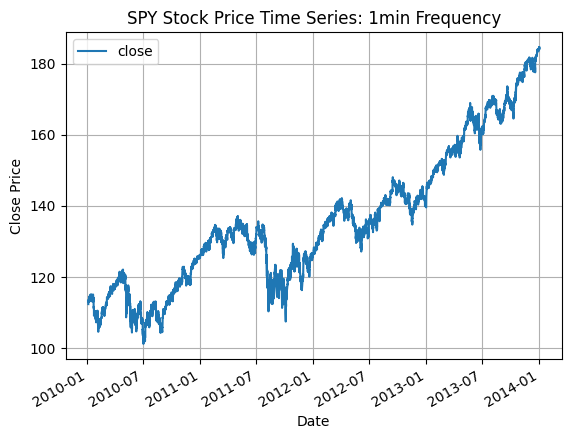

In [6]:
base_path = '/content/drive/My Drive/DSP/'

SPY_1m = pd.read_csv(base_path + "1_min_SPY_2008-2021.csv/1_min_SPY_2008-2021.csv", index_col=False, parse_dates=['date'], infer_datetime_format=True)
SPY_1m = SPY_1m[["date", "close"]]
SPY_1m.drop_duplicates(inplace=True)
SPY_1m = SPY_1m.sort_values(by='date')
SPY_1m.reset_index(drop=True, inplace=True)
SPY_1m.index = SPY_1m.pop('date')
SPY_1m = filtertime(SPY_1m, '2010-01-01 07:30:00', '2014-01-01 07:30:00')
print(SPY_1m.isna().sum().sum())
print(SPY_1m)
SPY_1m.plot()
plt.title('SPY Stock Price Time Series: 1min Frequency')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

### 2. Synthetic random walk time series

0
                     close
2023-01-01 00:00:00      0
2023-01-01 00:01:00     -1
2023-01-01 00:02:00      0
2023-01-01 00:03:00     -1
2023-01-01 00:04:00     -2
...                    ...
2023-12-31 23:55:00    115
2023-12-31 23:56:00    114
2023-12-31 23:57:00    113
2023-12-31 23:58:00    112
2023-12-31 23:59:00    111

[525600 rows x 1 columns]


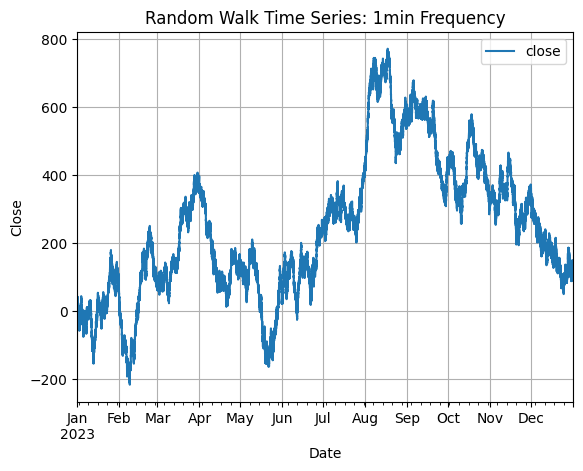

In [7]:
# Seed for reproducibility
np.random.seed(42)

# Generate datetime index for one year with one-minute intervals
start_date = pd.Timestamp("2023-01-01 00:00:00")
end_date = pd.Timestamp("2023-12-31 23:59:00")
date_range = pd.date_range(start=start_date, end=end_date, freq='T')

# Generate random walk data spanning the length of date_range
initial_value = 0
n_points_new = len(date_range)
steps_new = np.random.choice([-1, 1], size=n_points_new-1)  # Subtract 1 for the initial value
time_series_new = np.concatenate(([initial_value], np.cumsum(steps_new)))

# Create DataFrame with the datetime index
rw_df = pd.DataFrame(time_series_new, columns=['Value'], index=date_range)
rw_df.rename(columns={"Value":"close"}, inplace=True)
print(rw_df.isna().sum().sum())
print(rw_df)
# Plot the generated random walk data
# plt.figure(figsize=(12, 6))
rw_df.plot()
plt.title('Random Walk Time Series: 1min Frequency')
plt.xlabel('Date')
plt.ylabel('Close')
plt.grid(True)
plt.show()

### 3. Reyes financial dataset (Euro-dollar Exchange)

In [8]:
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl.styles.stylesheet")

base_path = '/content/drive/My Drive/DSP/'

Reyes_2005 = pd.DataFrame(pd.read_excel(base_path + "Reyes/EURUSD_M1_2005.xlsx", index_col=False, header=None))[[0,4]]
Reyes_2006 = pd.DataFrame(pd.read_excel(base_path + "Reyes/EURUSD_M1_2006.xlsx", index_col=False, header=None))[[0,4]]
Reyes_2007 = pd.DataFrame(pd.read_excel(base_path + "Reyes/EURUSD_M1_2007.xlsx", index_col=False, header=None))[[0,4]]
Reyes_2008 = pd.DataFrame(pd.read_excel(base_path + "Reyes/EURUSD_M1_2008.xlsx", index_col=False, header=None))[[0,4]]
Reyes_2009 = pd.DataFrame(pd.read_excel(base_path + "Reyes/EURUSD_M1_2009.xlsx", index_col=False, header=None))[[0,4]]
Reyes_2010 = pd.DataFrame(pd.read_excel(base_path + "Reyes/EURUSD_M1_2010.xlsx", index_col=False, header=None))[[0,4]]
Reyes_2011 = pd.DataFrame(pd.read_excel(base_path + "Reyes/EURUSD_M1_2011.xlsx", index_col=False, header=None))[[0,4]]
Reyes_2012 = pd.DataFrame(pd.read_excel(base_path + "Reyes/EURUSD_M1_2012.xlsx", index_col=False, header=None))[[0,4]]
Reyes_2013 = pd.DataFrame(pd.read_excel(base_path + "Reyes/EURUSD_M1_2013.xlsx", index_col=False, header=None))[[0,4]]
Reyes_2014 = pd.DataFrame(pd.read_excel(base_path + "Reyes/EURUSD_M1_2014.xlsx", index_col=False, header=None))[[0,4]]
Reyes_2015 = pd.DataFrame(pd.read_excel(base_path + "Reyes/EURUSD_M1_2015.xlsx", index_col=False, header=None))[[0,4]]

0
0
                       close
date                        
2006-01-02 19:00:00  1.18170
2006-01-02 19:05:00  1.18250
2006-01-02 19:10:00  1.18270
2006-01-02 19:15:00  1.18330
2006-01-02 19:20:00  1.18420
...                      ...
2014-12-31 16:35:00  1.20981
2014-12-31 16:40:00  1.20977
2014-12-31 16:45:00  1.20974
2014-12-31 16:50:00  1.20969
2014-12-31 16:55:00  1.20976

[946056 rows x 1 columns]


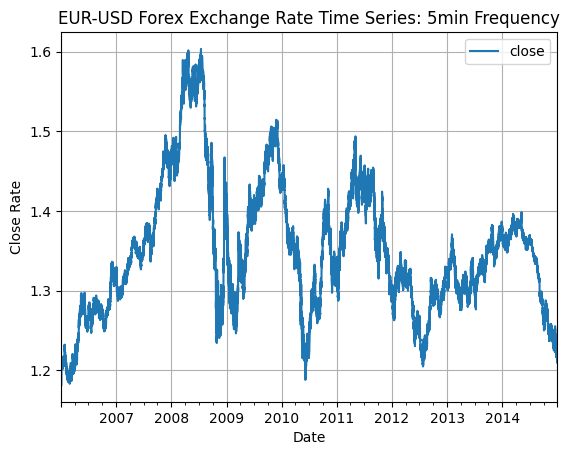

In [9]:
Reyes_1m = pd.concat([Reyes_2005,Reyes_2006,Reyes_2007,Reyes_2008,Reyes_2009,Reyes_2010,Reyes_2011,Reyes_2012,Reyes_2013,Reyes_2014,Reyes_2015], ignore_index=True)
Reyes_1m.rename(columns={0:"date", 4:"close"}, inplace=True)
Reyes_1m.drop_duplicates(inplace=True)
Reyes_1m = Reyes_1m.sort_values(by="date")
Reyes_1m.reset_index(drop=True, inplace=True)
Reyes_1m.index = Reyes_1m.pop("date")
Reyes_1m = filtertime(Reyes_1m, '2006-01-01 00:00:00', '2014-12-31 23:59:00')
Reyes_5m = Reyes_1m.resample("5Min").nearest()
print(Reyes_1m.isna().sum().sum())
print(Reyes_5m.isna().sum().sum())
print(Reyes_5m)
Reyes_5m.plot()
plt.title('EUR-USD Forex Exchange Rate Time Series: 5min Frequency')
plt.xlabel('Date')
plt.ylabel('Close Rate')
plt.grid(True)
plt.show()

### 4. Bitcoin Dataset (Kaggle)

In [10]:
base_path = '/content/drive/My Drive/DSP/'

BTC_2017 = pd.DataFrame(pd.read_csv(base_path + 'BTC/BTC-2017min.csv', index_col=False, header=None, low_memory=False))[[1,6]]
BTC_2018 = pd.DataFrame(pd.read_csv(base_path + 'BTC/BTC-2018min.csv', index_col=False, header=None, low_memory=False))[[1,6]]
BTC_2019 = pd.DataFrame(pd.read_csv(base_path + 'BTC/BTC-2019min.csv', index_col=False, header=None, low_memory=False))[[1,6]]
BTC_2020 = pd.DataFrame(pd.read_csv(base_path + 'BTC/BTC-2020min.csv', index_col=False, header=None, low_memory=False))[[1,6]]
BTC_2021 = pd.DataFrame(pd.read_csv(base_path + 'BTC/BTC-2021min.csv', index_col=False, header=None, low_memory=False))[[1,6]]

0
                        close
date                         
2017-01-01 00:01:00    966.34
2017-01-01 00:02:00    966.37
2017-01-01 00:03:00    966.37
2017-01-01 00:04:00    966.37
2017-01-01 00:05:00    966.43
...                       ...
2021-12-31 23:55:00  46259.35
2021-12-31 23:56:00  46249.35
2021-12-31 23:57:00  46245.17
2021-12-31 23:58:00  46175.48
2021-12-31 23:59:00  46214.37

[2590118 rows x 1 columns]


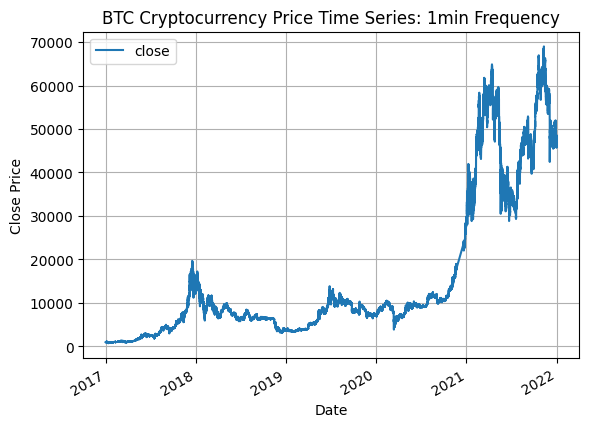

In [11]:
BTC_1m = pd.concat([BTC_2017, BTC_2018, BTC_2019, BTC_2020, BTC_2021], ignore_index=True)
BTC_1m.rename(columns={1:"date", 6:"close"}, inplace=True)
BTC_1m['close'] = pd.to_numeric(BTC_1m['close'], errors='coerce')
BTC_1m.drop_duplicates(inplace=True)
BTC_1m = BTC_1m.sort_values(by="date")
BTC_1m.reset_index(drop=True, inplace=True)
BTC_1m = BTC_1m.iloc[:-1]
BTC_1m['date'] = pd.to_datetime(BTC_1m['date'])
BTC_1m.index = BTC_1m.pop("date")
BTC_1m = filtertime(BTC_1m, '2017-01-01 00:01:00', '2021-12-31 23:59:00')
print(BTC_1m.isna().sum().sum())
print(BTC_1m)
BTC_1m.plot()
plt.title('BTC Cryptocurrency Price Time Series: 1min Frequency')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

### Replace zeros with small value

In [12]:
def replace(df):
  df = df.copy()
  # print((df == 0).sum().sum())
  locations = df.where(df==0).stack().index.tolist()
  # print(locations)
  df = df.replace(0, 0.0001)
  # print((df == 0).sum().sum())
  return df

# Raw to symbolic boxplot time series

In [13]:
def rawtosymbolic(dataset, f, price):
    dataset = dataset.copy()
    # print(dataset.isna().sum().sum())
    # print(dataset.dtypes)

    # symbolic descriptive statistics
    min_data = (dataset.groupby(pd.Grouper(freq=f, origin="start_day")).min().dropna()).rename(columns={'close':'min'})
    q25_data = dataset.groupby(pd.Grouper(freq=f, origin="start_day")).quantile(q=0.25).dropna()
    q50_data = dataset.groupby(pd.Grouper(freq=f, origin="start_day")).quantile().dropna()
    q75_data = dataset.groupby(pd.Grouper(freq=f, origin="start_day")).quantile(q=0.75).dropna()
    # min_data = (q25_data - (1.5*(q75_data - q25_data))).rename(columns={'close':'min'})
    # max_data = (q75_data + (1.5*(q75_data - q25_data))).rename(columns={'close':'max'})
    max_data = (dataset.groupby(pd.Grouper(freq=f, origin="start_day")).max().dropna()).rename(columns={'close':'max'})

    # max_data -= q75_data
    q75_data -= q50_data
    q50_data -= q25_data
    # q25_data -= min_data

    # print(q50_data.isna().sum().sum())
    # print(q25_data.isna().sum().sum())
    # print(q75_data.isna().sum().sum())
    # print(len(q50_data))
    # print(len(q25_data))
    # print(len(q75_data))

    # symbolic table
    sym_table = pd.DataFrame(columns=["Q1", "Q2", "Q3"])
    # sym_table["min"] = min_data[price]
    sym_table["Q1"] = q25_data[price]
    sym_table["Q2"] = q50_data[price]
    sym_table["Q3"] = q75_data[price]
    # sym_table["max"] = max_data[price]

    # filter original dataframe to price column and single point average using mean
    og_table = dataset[[price]].copy()
    sp_table = dataset.groupby(pd.Grouper(freq=f, origin="start_day")).mean().dropna()
    sp_table = sp_table[[price]]

    return sym_table, sp_table, og_table, min_data, max_data

def math_coherence(temp):
    temp = temp.copy()
    df = pd.DataFrame(temp)
    df.columns = ['Q1', 'Q2', 'Q3']
    # df['Q1'] += df['min']
    df['Q2'] += df['Q1']
    df['Q3'] += df['Q2']
    # df['max'] += df['Q3']
    return df

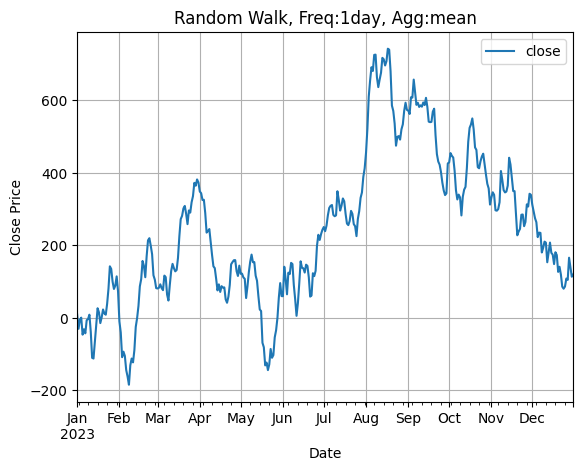

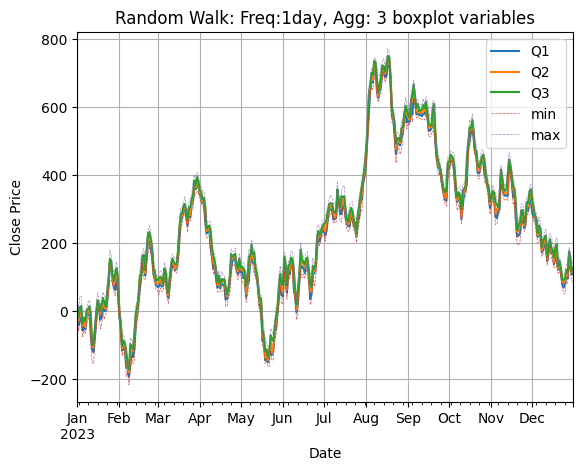

In [14]:
rw_sym_data, rw_sp_data, rw_raw_data, rw_min_data, rw_max_data = rawtosymbolic(rw_df, "1D", "close")
rw_sym_data = replace(rw_sym_data)
rw_sp_data = replace(rw_sp_data)
rw_raw_data = replace(rw_raw_data)

rw_sp_data.plot(label='close')
plt.title('Random Walk, Freq:1day, Agg:mean')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

ax = math_coherence(rw_sym_data).plot()
rw_min_data.plot(linestyle='--', ax=ax, linewidth=0.5, alpha=0.8)
rw_max_data.plot(linestyle='--', ax=ax, linewidth=0.5, alpha=0.8)
plt.title('Random Walk: Freq:1day, Agg: 3 boxplot variables')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

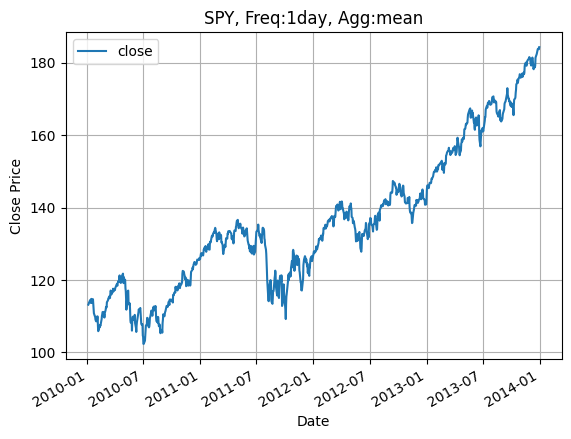

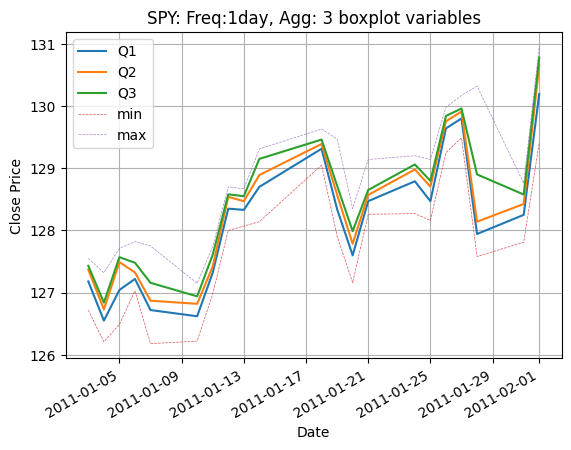

In [15]:
spy_sym_data, spy_sp_data, spy_raw_data, spy_min_data, spy_max_data = rawtosymbolic(SPY_1m, "1D", "close")
spy_sym_data = replace(spy_sym_data)
spy_sp_data = replace(spy_sp_data)
spy_raw_data = replace(spy_raw_data)

spy_sp_data.plot()
plt.title('SPY, Freq:1day, Agg:mean')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

ax = filtertime(math_coherence(spy_sym_data), '2011-01-01', '2011-02-01').plot()
filtertime(spy_min_data, '2011-01-01', '2011-02-01').plot(linestyle='--', ax=ax, linewidth=0.5, alpha=0.8)
filtertime(spy_max_data, '2011-01-01', '2011-02-01').plot(linestyle='--', ax=ax, linewidth=0.5, alpha=0.8)
plt.title('SPY: Freq:1day, Agg: 3 boxplot variables')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

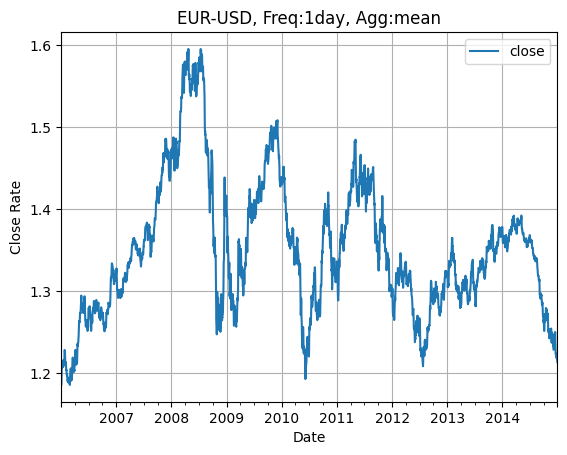

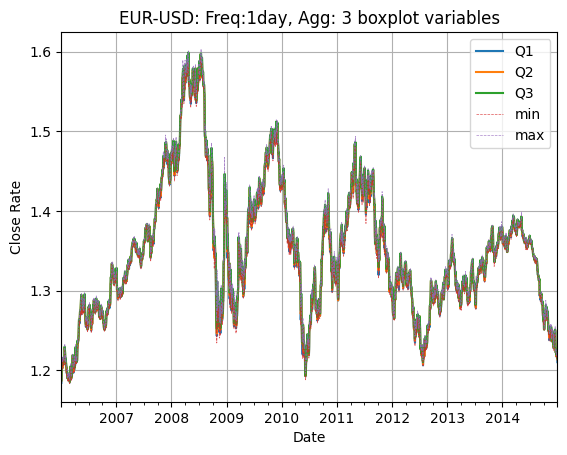

In [16]:
reyes_sym_data, reyes_sp_data, reyes_raw_data, reyes_min_data, reyes_max_data = rawtosymbolic(Reyes_5m, "1D", "close")
reyes_sym_data = replace(reyes_sym_data)
reyes_sp_data = replace(reyes_sp_data)
reyes_raw_data = replace(reyes_raw_data)

reyes_sp_data.plot()
plt.title('EUR-USD, Freq:1day, Agg:mean')
plt.xlabel('Date')
plt.ylabel('Close Rate')
plt.grid(True)
plt.show()

ax = filtertime(math_coherence(reyes_sym_data), '2005-01-01', '2015-01-01').plot()
filtertime(reyes_min_data, '2005-01-01', '2015-01-01').plot(linestyle='--', ax=ax, linewidth=0.5, alpha=0.8)
filtertime(reyes_max_data, '2005-01-01', '2015-01-01').plot(linestyle='--', ax=ax, linewidth=0.5, alpha=0.8)
plt.title('EUR-USD: Freq:1day, Agg: 3 boxplot variables')
plt.xlabel('Date')
plt.ylabel('Close Rate')
plt.grid(True)
plt.show()

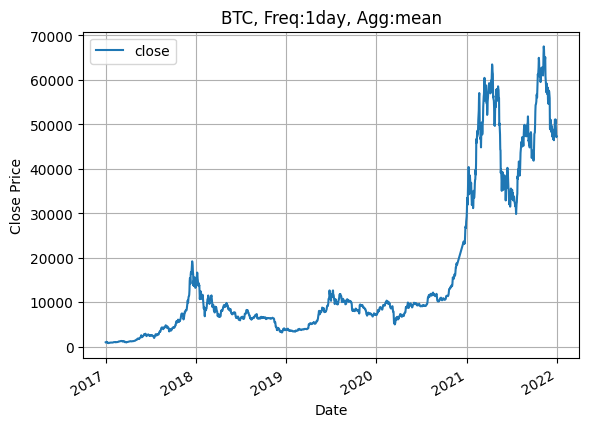

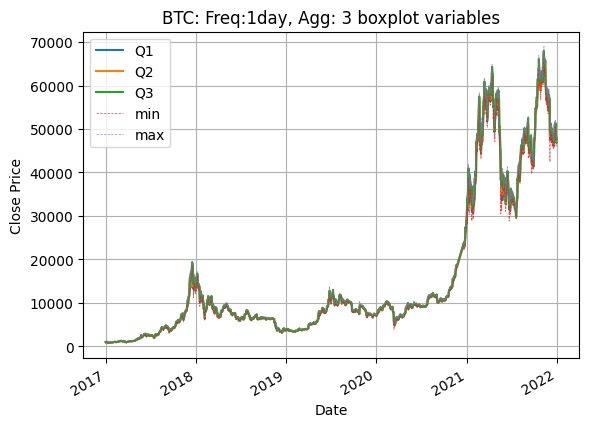

In [17]:
BTC_sym_data, BTC_sp_data, BTC_raw_data, BTC_min_data, BTC_max_data = rawtosymbolic(BTC_1m, "1D", "close")
BTC_sym_data = replace(BTC_sym_data)
BTC_sp_data = replace(BTC_sp_data)
BTC_raw_data = replace(BTC_raw_data)

BTC_sp_data.plot()
plt.title('BTC, Freq:1day, Agg:mean')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

ax = filtertime(math_coherence(BTC_sym_data), '2017-01-01','2022-01-01').plot()
filtertime(BTC_min_data, '2017-01-01','2022-01-01').plot(linestyle='--', ax=ax, linewidth=0.5, alpha=0.8)
filtertime(BTC_max_data, '2017-01-01','2022-01-01').plot(linestyle='--', ax=ax, linewidth=0.5, alpha=0.8)
plt.title('BTC: Freq:1day, Agg: 3 boxplot variables')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

# Train-Test-Split the data

In [18]:
def traintestsplit(df, val_size, test_size):
    df = df.copy()
    test_size_ = int(len(df)*(1-test_size))
    df_test = df[test_size_:]
    if val_size == 0:
      df_train = df[:test_size_]
      return df_train, df_test
    else:
      val_size_ = int(len(df)*(1-test_size-val_size))
      df_val = df[val_size_:test_size_]
      df_train = df[:val_size_]
      return df_train, df_val, df_test

# Stationarity analysis functions

In [19]:
# This function checks the stationarity of the input time series
def check_stationarity(df):
    df = df.copy()
    # rolling statistics
    rolling_mean = df.rolling(window = 12).mean()
    rolling_std = df.rolling(window = 12).std()
    # rolling statistics plot
    plt.plot(df, color = 'blue', label = 'Original')
    plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
    plt.xticks(rotation=45)
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.show()
    # acf plot
    plot_acf(df)
    plt.show()
    # pacf_plot
    plot_pacf(df)
    plt.show()
    # Dickey-Fuller statistical test
    result = adfuller(df.dropna())
    # print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    # print('Critical Values:')
    # for key, value in result[4].items():
        # print('\t{}: {}'.format(key, value))

    # if p-value is over threshold (and ADF statistic is far from the critical values)
    threshold = 0.05
    if result[1] > threshold:
        print('Time series is likely non-stationary.')
    else:
        print('Time series is likely stationary')

    return

In [20]:
# This function explores different transformations of the dataset, and checks the stationarity for each transformation.

def transformations(df, order):
    df = df.copy()
    # find logarithm of time series
    df_log = np.log(df)
    print("logarithm plot")
    plt.plot(df_log)
    plt.xticks(rotation=45)
    plt.show()
    check_stationarity(df_log)
    # subtract rolling mean
    rolling_mean = df.rolling(window=12).mean()
    df_log_minus_mean = df_log - rolling_mean
    df_log_minus_mean.dropna(inplace=True)
    print("Rolling mean,std and ACF plots")
    check_stationarity(df_log_minus_mean)
    # subtract rolling mean exponential decay
    # rolling_mean_exp_decay = df.ewm(halflife=12, min_periods=0, adjust=True).mean()
    # df_log_exp_decay = df_log - rolling_mean_exp_decay
    # df_log_exp_decay.dropna(inplace=True)
    # check_stationarity(df_log_exp_decay)
    # find differenced time series
    fig1, ax1 = plt.subplots()
    ax1.set_title('{} Order Differencing'.format(order))
    diff_df = df_log.copy()
    for i in range(order):
        diff_df = diff_df.diff()
    ax1.plot(diff_df)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Differenced Value')
    plt.tight_layout()
    plt.show()
    fig2, (ax2, ax3) = plt.subplots(1, 2)
    plot_pacf(diff_df.dropna(), ax=ax2)
    ax2.set_title('PACF')
    plot_acf(diff_df.dropna(), ax=ax3)
    ax3.set_title('ACF')

    # f = plt.figure()
    # ax1 = f.add_subplot(121)
    # ax1.set_title('{} Order Differencing'.format(order))
    # diff_df = df.copy()
    # for i in range(order):
    #     diff_df = diff_df.diff()
    # ax1.plot(diff_df)
    # ax2 = f.add_subplot(122)
    # plot_pacf(diff_df.dropna(), ax=ax2)
    plt.show()
    check_stationarity(diff_df)
    return

In [21]:
# This function can be used to confirm the differencing term, d, using black-box statistical tests.

def ADF_KPSS_PP(df):
    df = df.copy()
    # Test whether we should difference at the alpha=0.05 significance level
    adf_test = ADFTest(alpha=0.05)
    p_val, should_diff = adf_test.should_diff(df)

    # Estimate the number of differences using an ADF, KPSS, and PP test:
    n_adf = ndiffs(df, test='adf')
    n_kpss = ndiffs(df, test='kpss')
    n_pp = ndiffs(df, test='pp')

    print("p_val: ", p_val)
    print("should_diff: ", should_diff)
    print("n_adf: ", n_adf)
    print("n_kpss: ", n_kpss)
    print("n_pp: ", n_pp)

# Performance Metrics

In [22]:
def sMAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Compute the denominator, which is the sum of the absolute values of the actual and predicted values
    denominator = np.abs(y_true) + np.abs(y_pred)
    # Exclude cases where the denominator is zero to avoid division by zero
    mask = denominator != 0
    smape_value = (100/len(y_true)) * np.sum(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask])
    return round(smape_value, 4)

def MMRE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Exclude cases where y_true is zero to avoid division by zero
    mask = y_true != 0
    mmre_value = 100*np.mean(np.abs(y_true[mask] - y_pred[mask]) / y_true[mask])

    # Rounding to 3 significant figures
    return round(mmre_value, 4)

def performance(observed, forecasts):
    rmses = []
    smapes = []
    mmres = []

    for col in observed.columns:
        obs_col = observed[col]
        fcast_col = forecasts[col]

        rmse = round(sqrt(mean_squared_error(obs_col, fcast_col)),4)
        smape = sMAPE(obs_col, fcast_col)
        mmre = MMRE(obs_col, fcast_col)

        print(f"Performance for column {col}:")
        print("\tRMSE:", rmse)
        print("\tsMAPE:", smape)
        print("\tMMRE:", mmre)
        print("--------")

        rmses.append(rmse)
        smapes.append(smape)
        mmres.append(mmre)

    print("Overall Performance:")
    print("\tAverage RMSE:", round(np.mean(rmses),4))
    print("\tAverage sMAPE:", round(np.mean(smapes),4))
    print("\tAverage MMRE:", round(np.mean(mmres), 4))

In [23]:
# forecast = pd.read_csv(base_path + '/save_forecasts/btc_arima_ms_forecasted.csv')
# data = BTC_sym_data
# train, test_df = traintestsplit(data, val_size=0, test_size=0.1)
# test = math_coherence(test_df)

# test['min'] = (test['Q1'] - (1.5*(test['Q3'] - test['Q1'])))
# test['max'] = (test['Q3'] + (1.5*(test['Q3'] - test['Q1'])))
# forecast['min'] = (forecast['Q1'] - (1.5*(forecast['Q3'] - forecast['Q1'])))
# forecast['max'] = (forecast['Q3'] + (1.5*(forecast['Q3'] - forecast['Q1'])))

# performance(test, forecast)

# Univariate Forecasting

### ARIMA

##### Visualize the data

In [ ]:
data = reyes_sym_data.copy()

In [ ]:
train, test = traintestsplit(data['q25'], val_size=0, test_size=0.1)

plt.plot(train.index, train)
plt.plot(test.index, test)
plt.legend(['Train', 'Test'])
plt.ylabel('Close Price')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.title('Data Visualisation')

##### manual statistical (stationarity analysis functions)

--CHECK STATIONARITY--


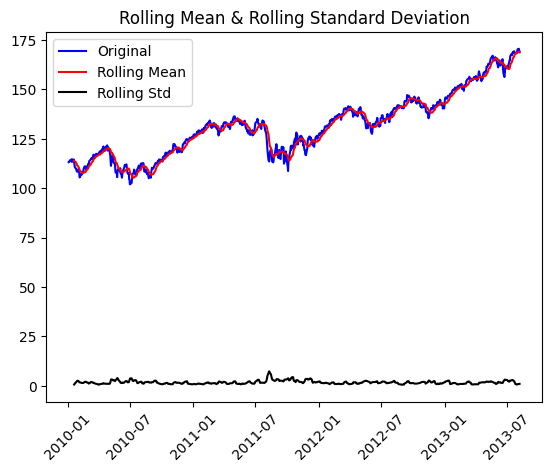

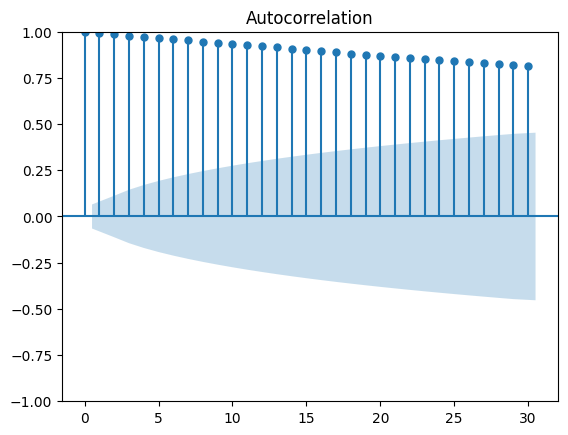

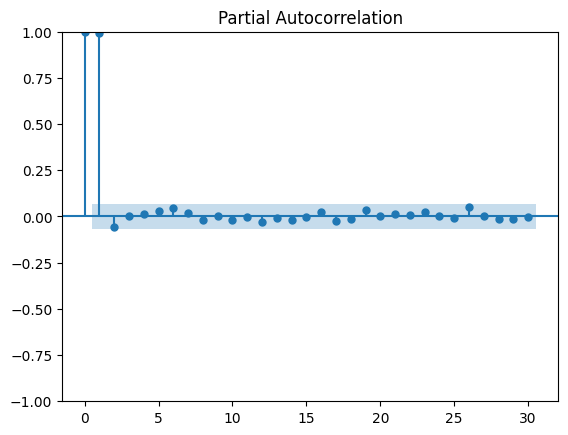

p-value: 0.9625584050540983
Time series is likely non-stationary.


In [ ]:
print("--CHECK STATIONARITY--")
check_stationarity(train)

--EXPLORE TRANSFORMATIONS--
logarithm plot


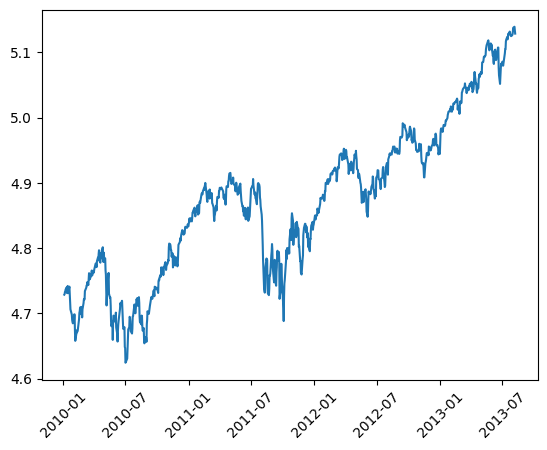

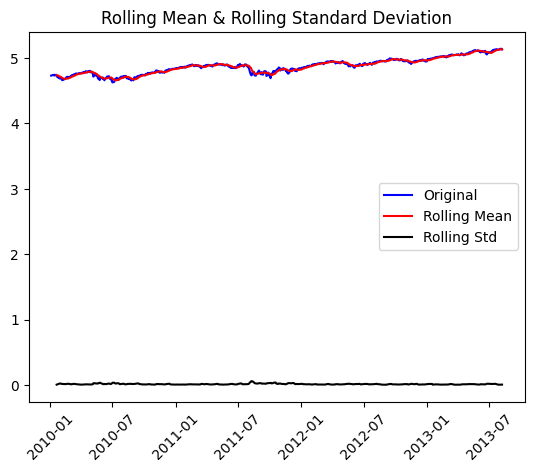

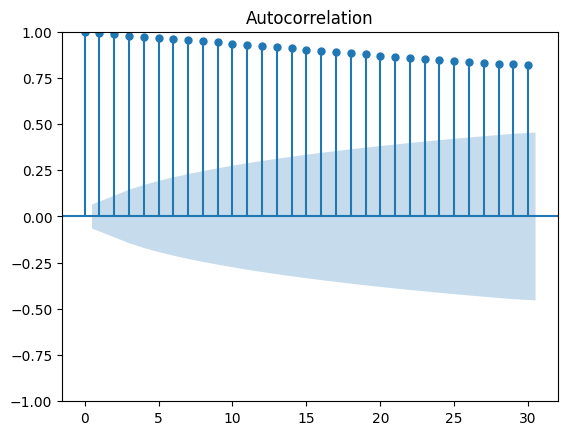

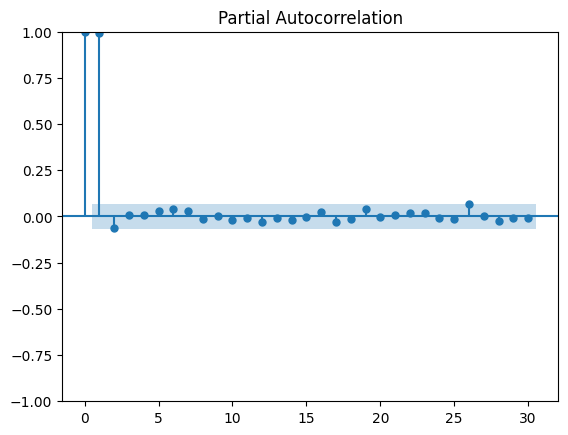

p-value: 0.9246740802154733
Time series is likely non-stationary.
Rolling mean,std and ACF plots


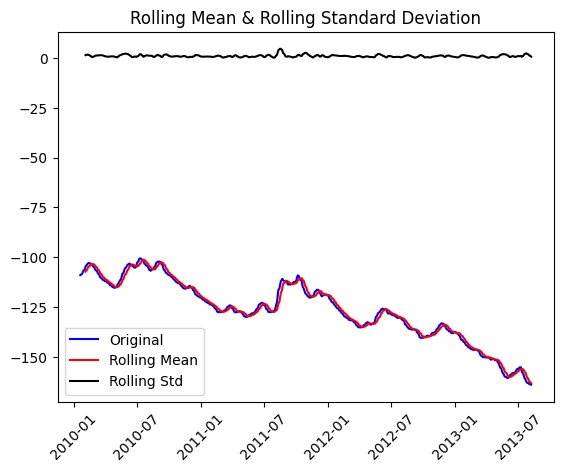

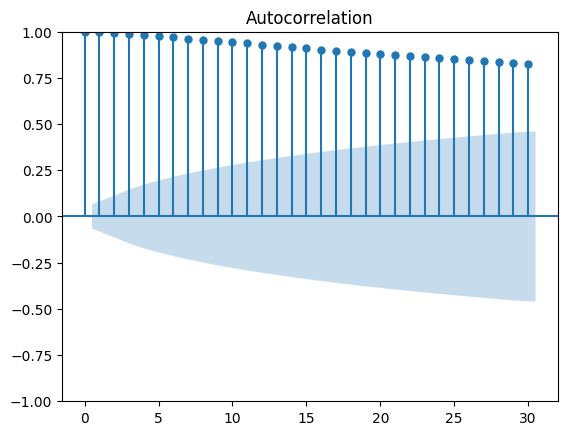

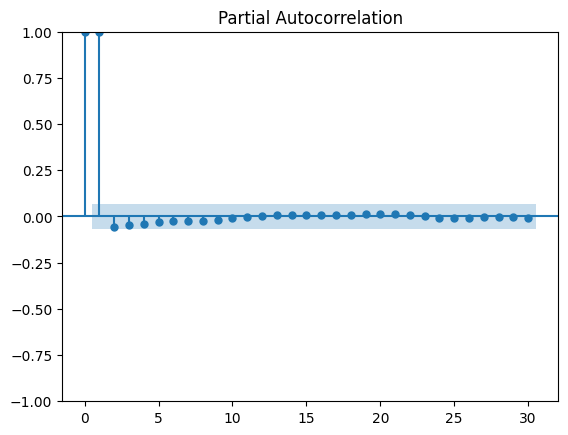

p-value: 0.9693637901822448
Time series is likely non-stationary.


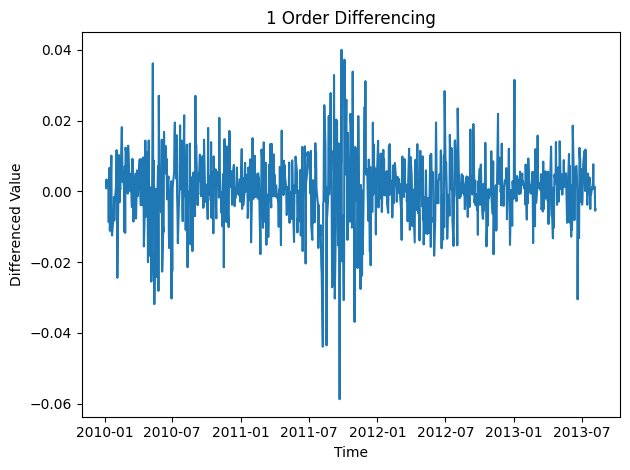

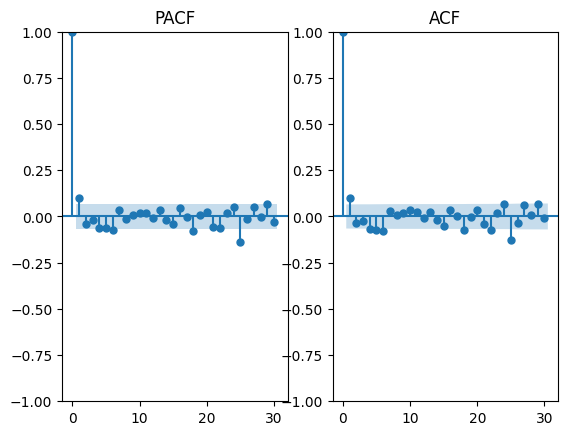

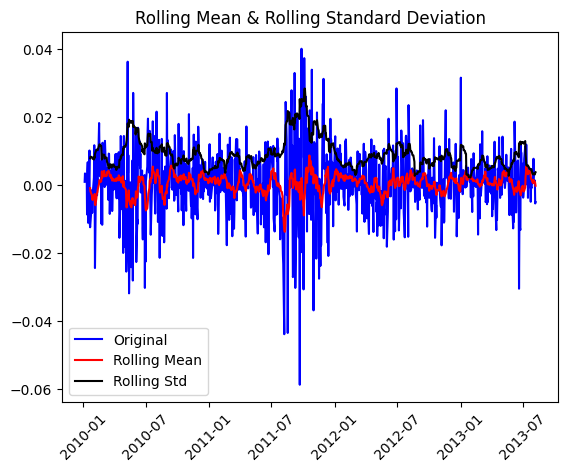

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


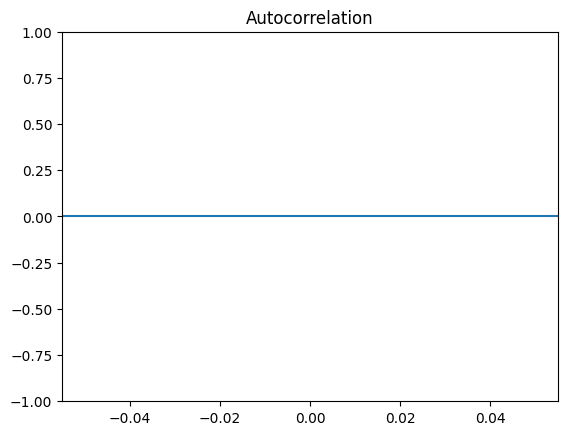

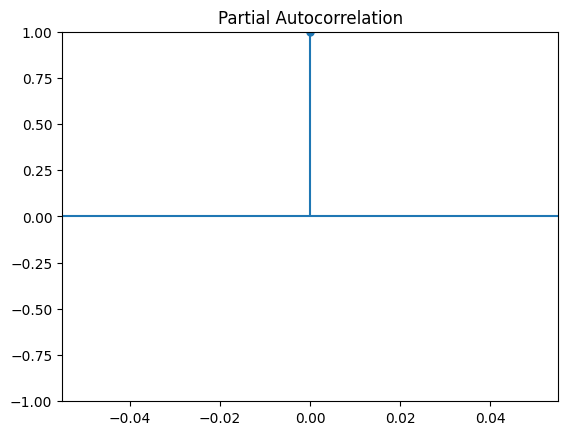

p-value: 7.167536862556278e-27
Time series is likely stationary


In [ ]:
print("--EXPLORE TRANSFORMATIONS--")
transformations(train, 1)

In [ ]:
print("--CONFIRM DIFFERENCING ORDER--")
ADF_KPSS_PP(train)

--CONFIRM DIFFERENCING ORDER--
p_val:  0.4917658755805071
should_diff:  True
n_adf:  1
n_kpss:  1
n_pp:  1


In [ ]:
ms_order = [(0,1,1)]

##### Model evaluation functions

In [23]:
def quick_test(train, test, param, f):
    history = train.copy()
    history.index = history.index.to_period(f)
    arima = ARIMA(history, order=param).fit()
    # residuals = arima.resid[1:]
    # fig, ax = plt.subplots(1,2)
    # # Check that the residuals look random and general.
    # residuals.plot(title='Residuals', ax=ax[0])
    # # Check that the density looks normally distributed, with a mean of around zero.
    # residuals.plot(title='Density', kind='kde', ax=ax[1])
    # plt.show()
    # # Check that the lower lags barely show any significant spikes. This verifies that the residuals are close to white noise.
    # acf_res = plot_acf(residuals)
    # pacf_res = plot_pacf(residuals)

    pred = arima.get_prediction(start=train.index[0], end=train.index[-1], dynamic=False).predicted_mean
    pred.index = train.index
    pred = pred.iloc[1:]

    history = history.values.flatten().tolist()
    forecasts = []
    for t in range(0, len(test)-4, 5):
        arima = ARIMA(history, order=param).fit()
        forecasts.extend(arima.get_forecast(steps=5).predicted_mean)
        for i in range(5):
            history.append(test.iloc[t+i])
    forecasts_df = pd.DataFrame(forecasts, index=test.index[:len(forecasts)])
    # print(arima.summary())

    return pred, forecasts_df

In [24]:
# from pmdarima import ARIMA
# from statsmodels.tsa.arima.model import ARIMA as smARIMA
# import warnings
# from statsmodels.tools.sm_exceptions import ConvergenceWarning
# warnings.simplefilter('ignore', ConvergenceWarning)

# def quick_test(train, test, order, f):

#     history = train.copy()
#     history.index = history.index.to_period(f)

#     arima = ARIMA(order=order).fit(history)
#     smarima = smARIMA(history, order=order).fit()

#     # residuals = pd.Series(arima.resid(), index=history.index[1:])
#     # fig, ax = plt.subplots(1,2)
#     # residuals.plot(title='Residuals', ax=ax[0])
#     # residuals.plot(title='Density', kind='kde', ax=ax[1])
#     # plt.show()

#     # plot_acf(residuals)
#     # plot_pacf(residuals)

#     pred = smarima.get_prediction(start=train.index[0], end=train.index[-1], dynamic=False).predicted_mean
#     pred.index = train.index
#     pred = pred.iloc[1:]

#     forecasts = []
#     for t in test.index:
#         forecasts.append(arima.predict(n_periods=1)[0])
#         arima.update(test.loc[[t]])

#     forecasts_df = pd.DataFrame(forecasts, index=test.index)

#     return pred, forecasts_df

In [25]:
# pred, forecasts_df = quick_test(train, test['q25'], (3,1,0), 'D')
# plt.figure(figsize=(10, 6))
# plt.plot(train.index, train, label='Train')
# plt.plot(test.index, test, label='Test')
# plt.plot(forecasts_df.index, forecasts_df, label='Forecast')
# plt.xticks(rotation=45)

# plt.legend()
# plt.grid(True)
# plt.show()

In [26]:
def plot_forecasts(train, test, ms_pred_df, aa_pred_df, cv_pred_df, ms_forecast_df, aa_forecast_df, cv_forecast_df):

    forecast_dfs = [ms_forecast_df, cv_forecast_df, aa_forecast_df]
    forecast_labels = ['VS Testing Predictions', 'CV Testing Predictions', 'AA Testing Predictions']

    if len(test.columns) != 1:
        test['min'] = (test['Q1'] - (1.5*(test['Q3'] - test['Q1'])))
        test['max'] = (test['Q3'] + (1.5*(test['Q3'] - test['Q1'])))
        ms_forecast_df['min'] = (ms_forecast_df['Q1'] - (1.5*(ms_forecast_df['Q3'] - ms_forecast_df['Q1'])))
        ms_forecast_df['max'] = (ms_forecast_df['Q3'] + (1.5*(ms_forecast_df['Q3'] - ms_forecast_df['Q1'])))
        cv_forecast_df['min'] = (cv_forecast_df['Q1'] - (1.5*(cv_forecast_df['Q3'] - cv_forecast_df['Q1'])))
        cv_forecast_df['max'] = (cv_forecast_df['Q3'] + (1.5*(cv_forecast_df['Q3'] - cv_forecast_df['Q1'])))
        aa_forecast_df['min'] = (aa_forecast_df['Q1'] - (1.5*(aa_forecast_df['Q3'] - aa_forecast_df['Q1'])))
        aa_forecast_df['max'] = (aa_forecast_df['Q3'] + (1.5*(aa_forecast_df['Q3'] - aa_forecast_df['Q1'])))

        for forecast_df, forecast_label in zip(forecast_dfs, forecast_labels):
            plt.figure(figsize=(10, 6))
            plt.plot(test.index, test, label='Testing Observations', lw=2.0, color='orange')
            plt.plot(forecast_df.index, forecast_df, label=forecast_label, color='green')

            orange_line = mlines.Line2D([], [], color='orange', markersize=15, label='Testing Observations')
            green_line = mlines.Line2D([], [], color='green', markersize=15, label=forecast_label)
            plt.legend(handles=[orange_line, green_line])

            plt.title(f'All symbolic rates ({forecast_label})')
            plt.grid(True)
            plt.show()

    for i,col in enumerate(test.columns):
        for forecast_df, forecast_label in zip(forecast_dfs, forecast_labels):
            plt.figure(figsize=(10, 6))
            plt.plot(test.index, test[col], label=f'{col} Testing Observations', lw=2.0, color='orange')
            plt.plot(forecast_df.index, forecast_df[col], label=f'{col} {forecast_label}', color='green')
            plt.legend()
            plt.title(f'{col} rates ({forecast_label})')
            plt.grid(True)
            plt.show()

    print("MS:")
    performance(test[:-4], ms_forecast_df)
    print("AA:")
    performance(test[:-4], aa_forecast_df)
    print("CC:")
    performance(test[:-4], cv_forecast_df)

    # ms_forecast_df.to_csv(base_path + '/save_forecasts/spy_arima_sp_ms_forecasted.csv', index=False)
    # aa_forecast_df.to_csv(base_path + '/save_forecasts/spy_arima_sp_aa_forecasted.csv', index=False)
    # cv_forecast_df.to_csv(base_path + '/save_forecasts/spy_arima_sp_cv_forecasted.csv', index=False)

##### CV

In [27]:
# from traitlets.traitlets import validate
# import concurrent.futures
# from concurrent.futures import ProcessPoolExecutor
# import pandas as pd
# import numpy as np
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import TimeSeriesSplit
# import itertools
# import warnings

# def evaluate_arima_model(df, order, f):
#         df = df.copy()
#         error_scores = []
#         tscv = TimeSeriesSplit(n_splits=3)
#         for train_index, val_index in tscv.split(df):
#             train, val = df.iloc[train_index], df.iloc[val_index]
#             with warnings.catch_warnings():
#                 warnings.filterwarnings("ignore") # ignore all warnings
#                 pred, forecasts = quick_test(train, val, order, f)
#                 error = mean_squared_error(val, forecasts)
#                 error_scores.append(error)
#         return order, np.mean(error_scores)

# def cv_approach(df, f):
#     # Define the p, d and q parameters to take any value between 1 and 5
#     p = d = q = range(0, 3)

#     # Generate all different combinations of p, q and q triplets
#     pdq = list(itertools.product(p, d, q))

#     best_score, best_cfg = float("inf"), None
#     with concurrent.futures.ProcessPoolExecutor() as executor:
#         futures = {executor.submit(evaluate_arima_model, df, order, f): order for order in pdq}
#         for future in concurrent.futures.as_completed(futures):
#             order, mse = future.result()
#             if mse < best_score:
#                 best_score, best_cfg = mse, order
#             # print('ARIMA%s MSE=%.3f' % (order, mse))

#     # print('Best ARIMA=%s MSE=%.3f' % (best_cfg, best_score))
#     return best_cfg

In [28]:
# out = cv_approach(train, f='D')
# out

In [29]:
warnings.simplefilter('ignore', ConvergenceWarning)

def evaluate_arima_model(df, order, f):
    df = df.copy()
    error_scores = []
    tscv = TimeSeriesSplit(n_splits=3)
    for train_index, val_index in tscv.split(df):
        train, val = df.iloc[train_index], df.iloc[val_index]
        print('progress..')
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")  # ignore all warnings
            pred, forecasts = quick_test(train, val, order, f)
            error = MMRE(val, forecasts)
            error_scores.append(error)
    return order, np.mean(error_scores)

def stepwise_search(df, f):
    p = d = q = [0, 1, 1]
    best_score = float("inf")
    best_cfg = (0, 0, 0)  # initial configuration

    improved = True  # flag to check if any improvements in the loop
    while improved:
        improved = False
        neighbors = get_neighbors(best_cfg, p, d, q)

        # Parallelize evaluations of neighbors
        with concurrent.futures.ProcessPoolExecutor() as executor:
            futures = {executor.submit(evaluate_arima_model, df, order, f): order for order in neighbors}
            for future in concurrent.futures.as_completed(futures):
                order, mse = future.result()
                if mse < best_score:
                    improved = True
                    best_score = mse
                    best_cfg = order

    return best_cfg

def get_neighbors(order, p_values, d_values, q_values):
    neighbors = []

    p, d, q = order
    if p+1 in p_values:
        neighbors.append((p+1, d, q))
    if p-1 in p_values:
        neighbors.append((p-1, d, q))
    if d+1 in d_values:
        neighbors.append((p, d+1, q))
    if d-1 in d_values:
        neighbors.append((p, d-1, q))
    if q+1 in q_values:
        neighbors.append((p, d, q+1))
    if q-1 in q_values:
        neighbors.append((p, d, q-1))

    return neighbors

In [30]:
# new = stepwise_search(train,'D')
# new

##### Auto Arima

In [31]:
# from pmdarima.arima import auto_arima

# def AutoArima(train, test, f):
#     history = train.copy()
#     history.index = history.index.to_period(f)
#     forecast_auto = []
#     best_params = []
#     model3 = auto_arima(history, stepwise=False, seasonal=False, n_jobs=-1)
#     pred_auto = model3.predict_in_sample()
#     pred_auto.index = train.index
#     pred_auto = pred_auto.iloc[1:]
#     history = history.values.flatten().tolist()
#     for t in range(len(test)):
#         model3 = auto_arima(history, stepwise=False, seasonal=False, n_jobs=-1)
#         forecast_auto.append(model3.predict(n_periods=1)[0])
#         history.append(test.iloc[t,0])
#         model3.summary()
#         best_params.append(model3.order)
#     forecast_auto_df = pd.DataFrame(forecast_auto, index=test.index)
#     return best_params, pred_auto, forecast_auto_df

In [32]:
warnings.simplefilter('ignore', ConvergenceWarning)

def AutoArima(train, test, f):
    history = train.copy()
    history.index = history.index.to_period(f)
    forecast_auto = []
    model3 = auto_arima(history, stepwise=True, seasonal=False, n_jobs=1)
    pred_auto = model3.predict_in_sample()
    pred_auto.index = train.index
    pred_auto = pred_auto.iloc[1:]
    best_params = model3.order
    # for t in test.index:
    #     forecast_auto.append(model3.predict(n_periods=1)[0])
    #     model3.update(test.loc[[t]])
    # forecast_auto_df = pd.DataFrame(forecast_auto, index=test.index)
    # return best_params, pred_auto, forecast_auto_df
    for t in range(0, len(test)-4, 5):
        forecast_auto.extend(model3.predict(n_periods=5))
        model3.update(test.iloc[t:t+5])
    forecast_auto_df = pd.DataFrame(forecast_auto, index=test.index[:len(forecast_auto)])
    return best_params, pred_auto, forecast_auto_df

In [33]:
# best_params, pred_auto, forecast_auto = AutoArima(train, test, f='D')
# best_params

In [34]:
# plt.figure(figsize=(10, 6))
# plt.plot(train.index, train, label='Train')
# plt.plot(test.index, test, label='Test')
# plt.plot(forecast_auto.index, forecast_auto, label='Forecast')
# plt.xticks(rotation=45)

# plt.legend()
# plt.grid(True)
# plt.show()

##### Arima pipeline

In [35]:
def arima_pipeline(data, ms_order, cv_order, f):
    train, test = traintestsplit(data, val_size=0, test_size=0.1)
    ms_pred_, cv_pred_, aa_pred_, ms_forecast_, cv_forecast_, aa_forecast_ = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    stationary_train, stationary_test = train.copy(), test.copy()
    stationary_train, stationary_test = np.log(stationary_train), np.log(stationary_test)
    for i, col in enumerate(train.columns):
        aa_order, aa_pred, aa_forecast = AutoArima(train[col], test[col], f)
        print('aa params {}: {}'.format(col, aa_order))
        aa_forecast_ = pd.concat([aa_forecast_,aa_forecast], axis=1)
        aa_pred_ = pd.concat([aa_pred_,aa_pred], axis=1)

        ms_pred, ms_forecast = quick_test(stationary_train[col], stationary_test[col], ms_order[i], f)
        ms_pred_ = pd.concat([ms_pred_,ms_pred], axis=1)
        ms_forecast_ = pd.concat([ms_forecast_,ms_forecast], axis=1)

        # cv_order = stepwise_search(train[col], f)
        print('cv params {}: {}'.format(col, cv_order[i]))
        cv_pred, cv_forecast = quick_test(train[col], test[col], cv_order[i], f)
        cv_pred_ = pd.concat([cv_pred_,cv_pred], axis=1)
        cv_forecast_ = pd.concat([cv_forecast_,cv_forecast], axis=1)

    aa_pred_.columns, aa_forecast_.columns = train.columns, test.columns
    ms_pred_.columns, ms_forecast_.columns = train.columns, test.columns
    cv_pred_.columns, cv_forecast_.columns = train.columns, test.columns

    ms_pred_, ms_forecast_ = np.exp(ms_pred_), np.exp(ms_forecast_)

    if len(train.columns) == 1:
        plot_forecasts(train, test, ms_pred_, aa_pred_, cv_pred_, ms_forecast_, aa_forecast_, cv_forecast_)
    else:
        ms_pred_df = math_coherence(ms_pred_)
        aa_pred_df = math_coherence(aa_pred_)
        ms_forecast_df = math_coherence(ms_forecast_)
        aa_forecast_df = math_coherence(aa_forecast_)
        train_df = math_coherence(train)
        test_df = math_coherence(test)
        cv_pred_df = math_coherence(cv_pred_)
        cv_forecast_df = math_coherence(cv_forecast_)
        plot_forecasts(train_df, test_df, ms_pred_df, aa_pred_df, cv_pred_df, ms_forecast_df, aa_forecast_df, cv_forecast_df)

In [36]:
# ms_order = [(1,1,1)]
# cv_order = [(1,0,0)]
ms_order = [(2,0,0),(1,0,1),(1,0,1)]
cv_order = [(0,0,1),(0,0,0),(0,0,0)]

aa params Q1: (0, 1, 1)
cv params Q1: (0, 0, 1)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


aa params Q2: (1, 1, 3)
cv params Q2: (0, 0, 0)
aa params Q3: (2, 1, 2)
cv params Q3: (0, 0, 0)


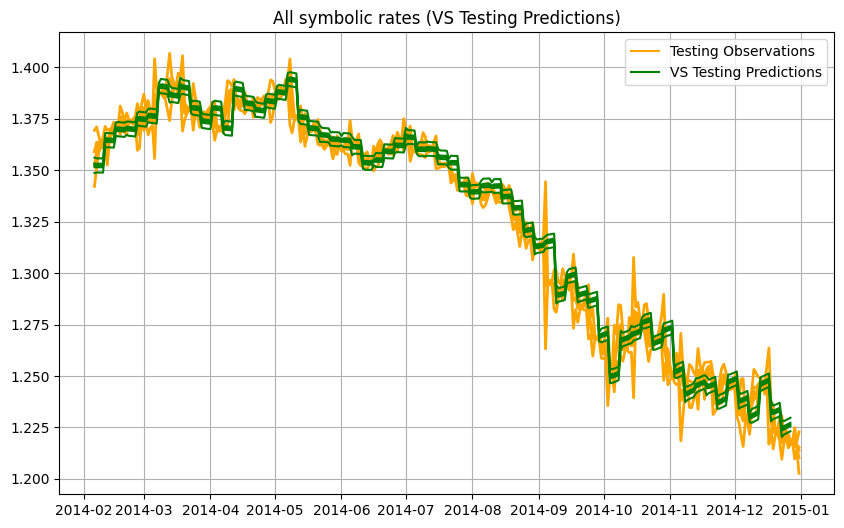

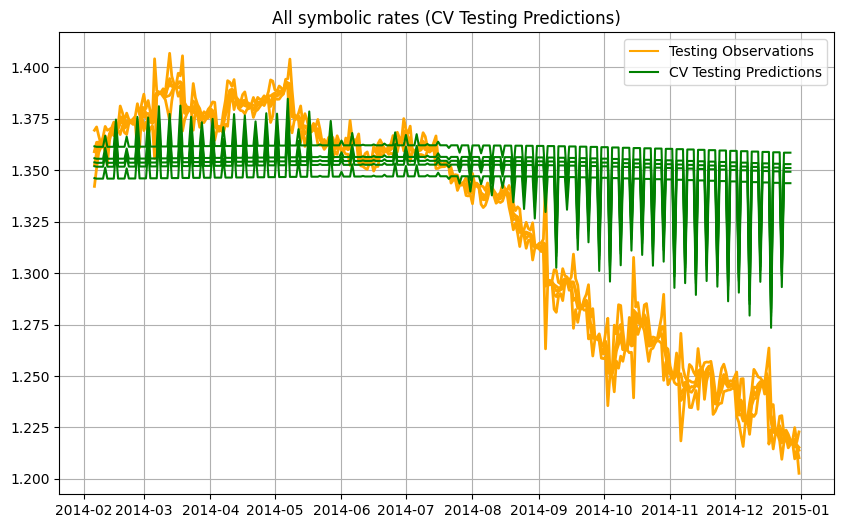

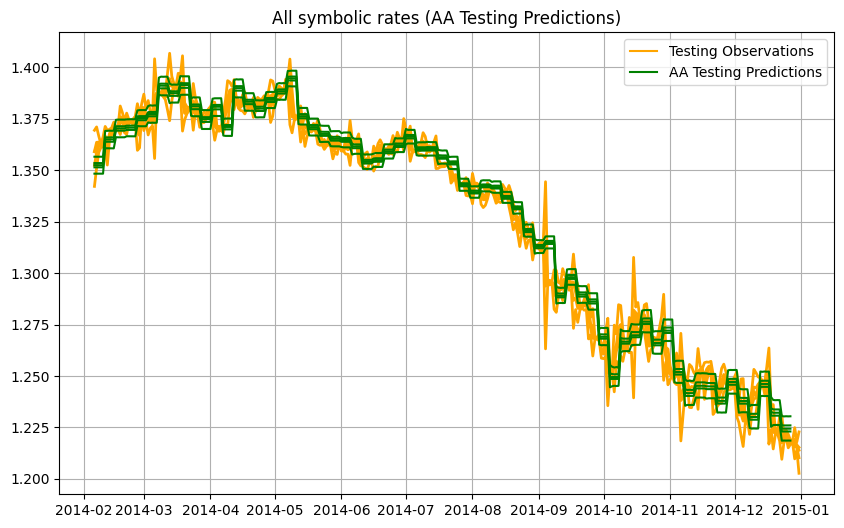

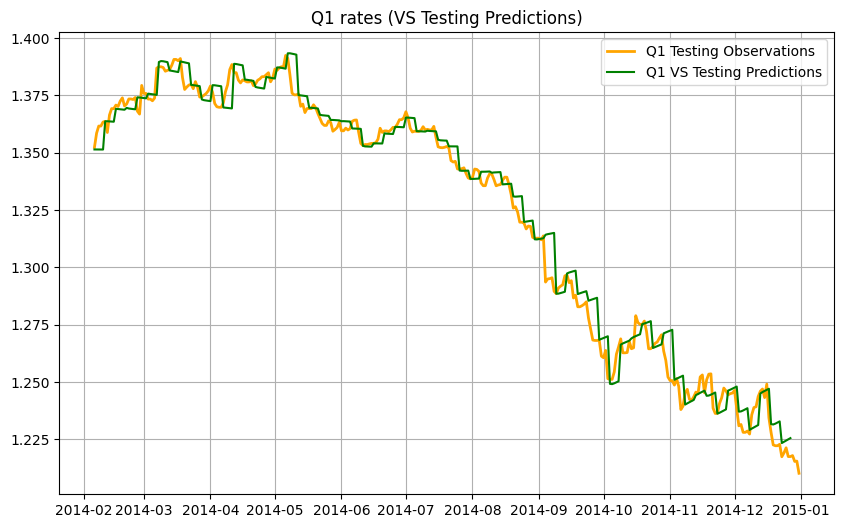

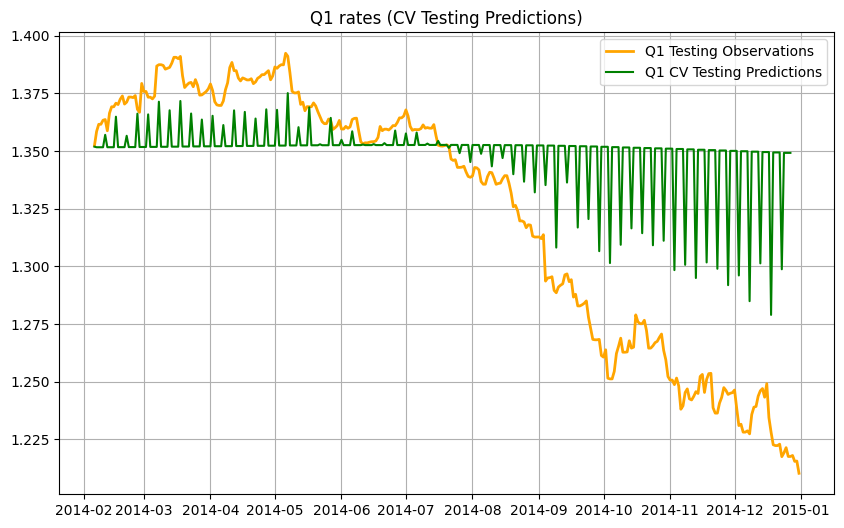

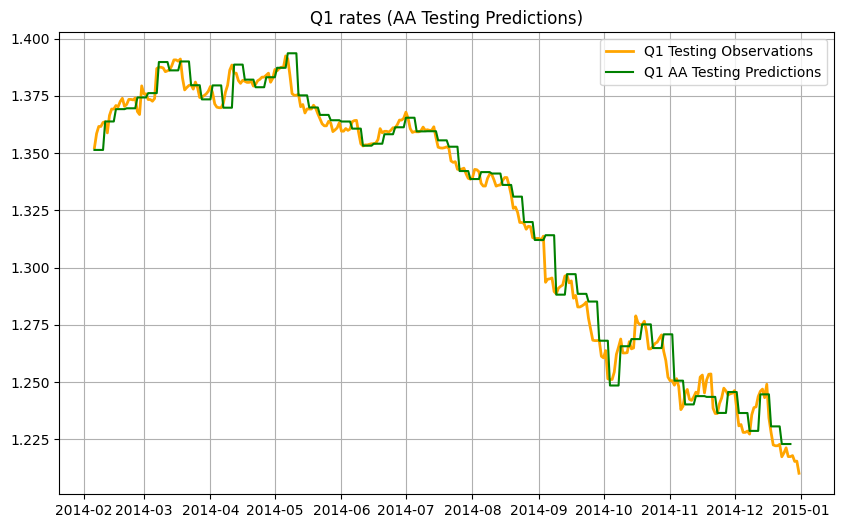

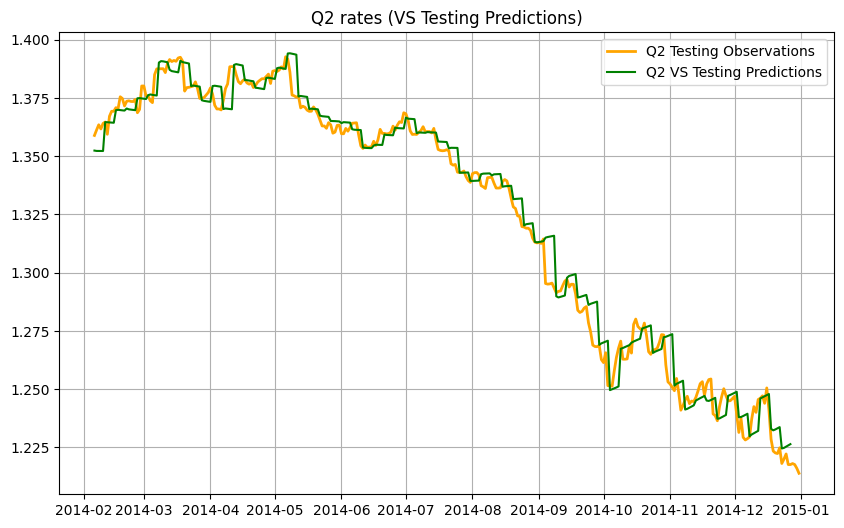

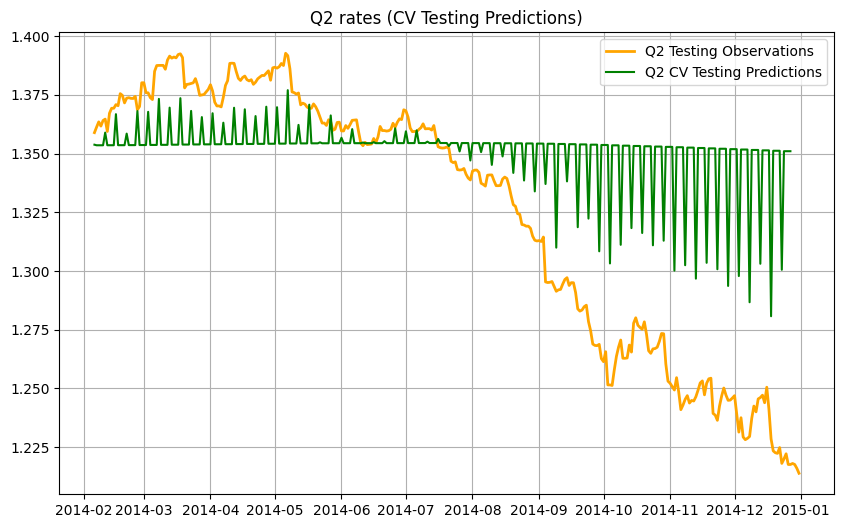

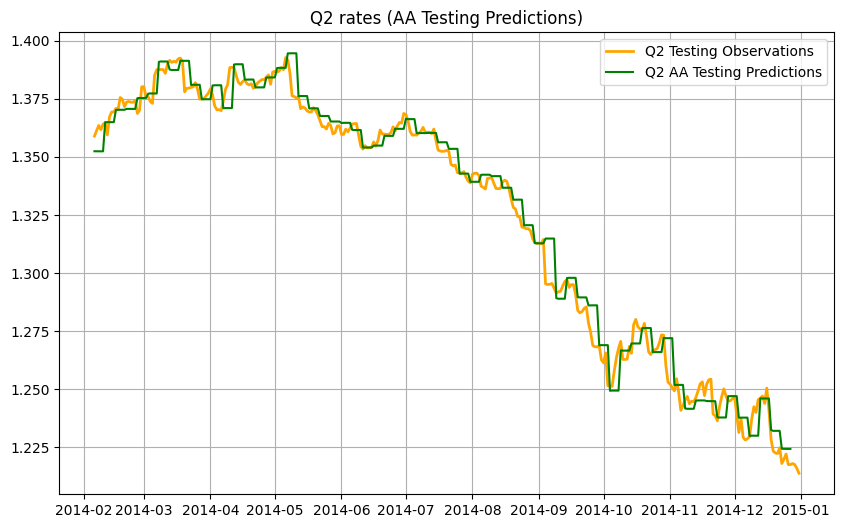

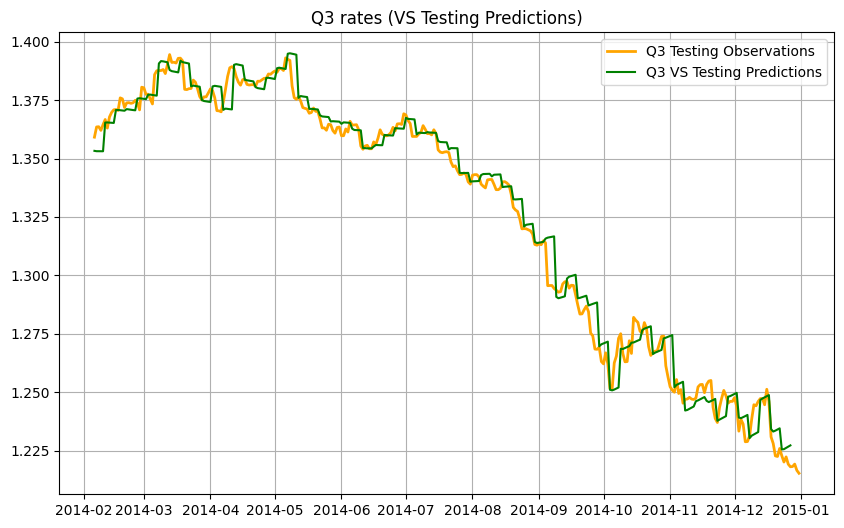

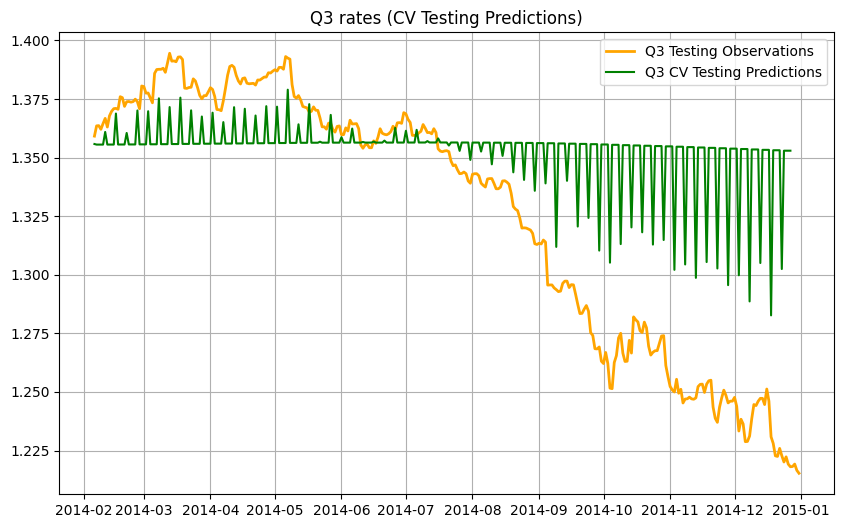

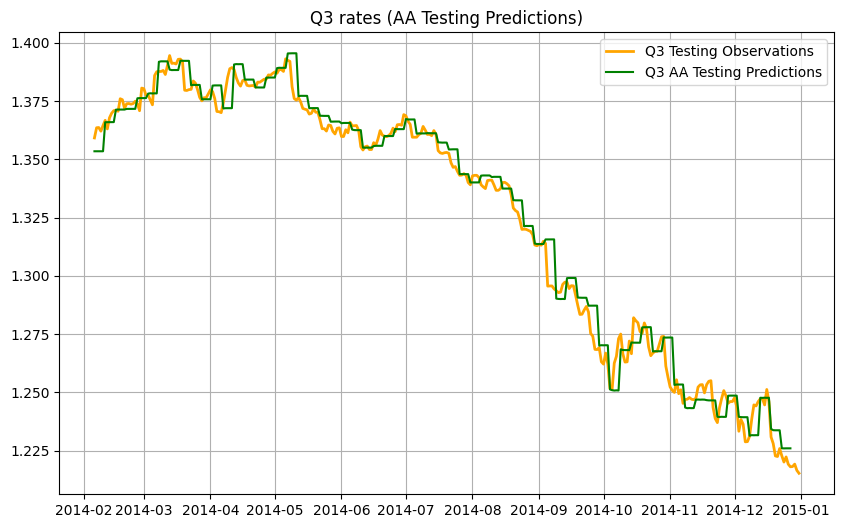

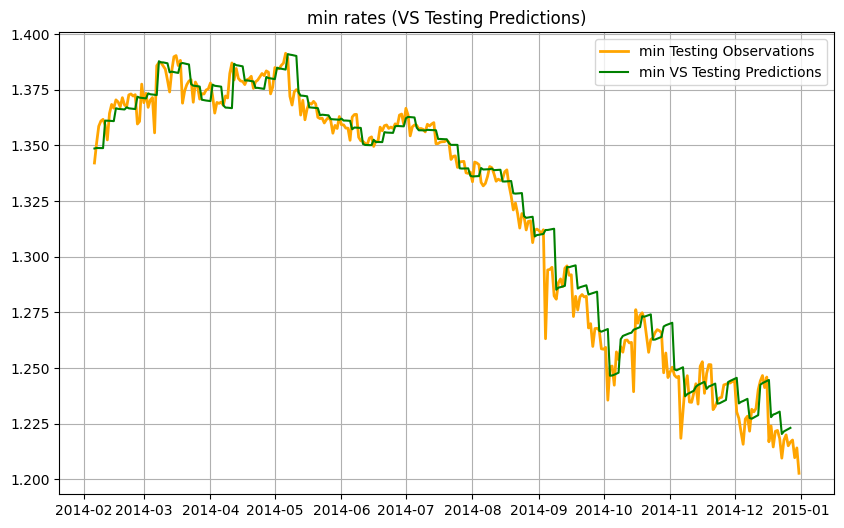

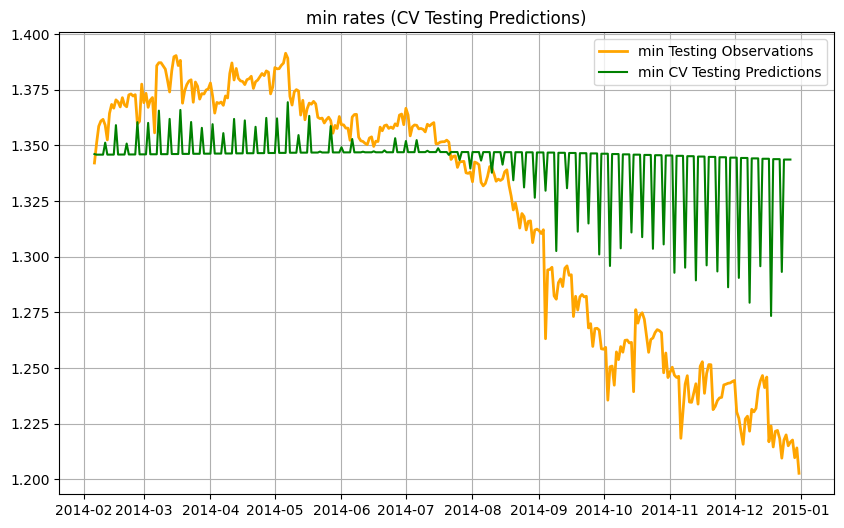

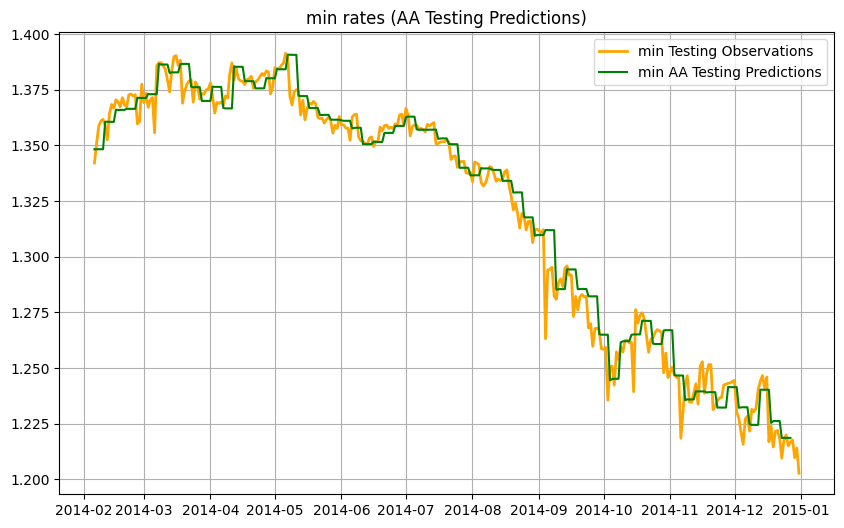

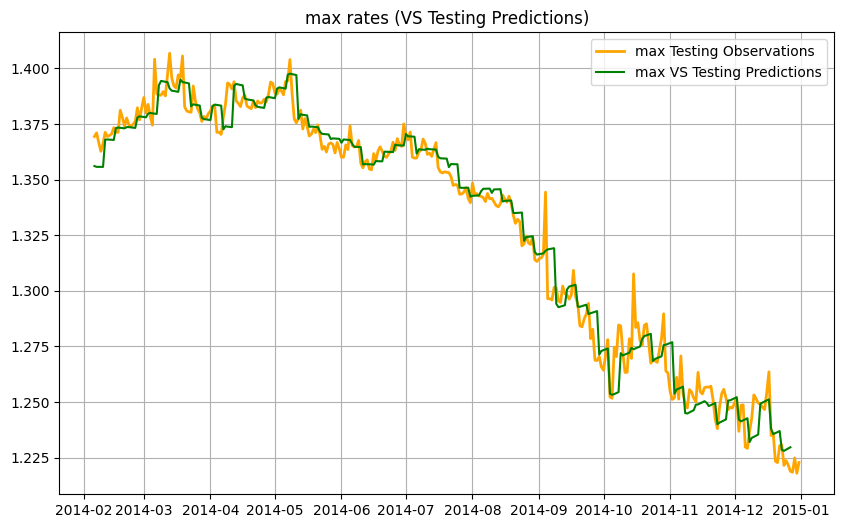

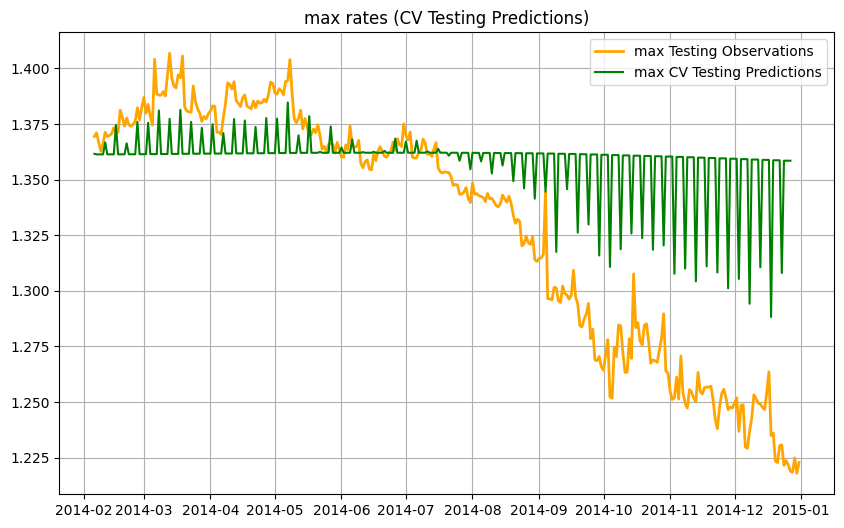

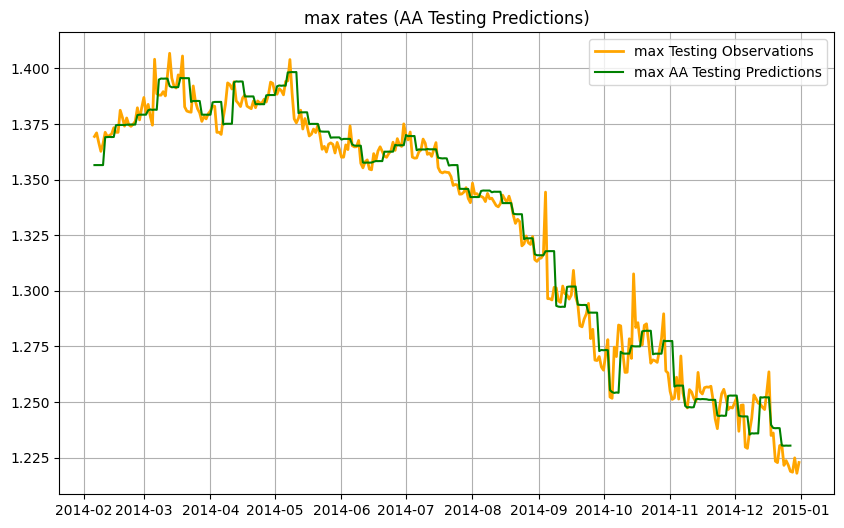

MS:
Performance for column Q1:
	RMSE: 0.0069
	sMAPE: 0.1896
	MMRE: 0.38
--------
Performance for column Q2:
	RMSE: 0.0069
	sMAPE: 0.1921
	MMRE: 0.3849
--------
Performance for column Q3:
	RMSE: 0.0067
	sMAPE: 0.1834
	MMRE: 0.3673
--------
Performance for column min:
	RMSE: 0.0087
	sMAPE: 0.2337
	MMRE: 0.4691
--------
Performance for column max:
	RMSE: 0.0082
	sMAPE: 0.224
	MMRE: 0.448
--------
Overall Performance:
	Average RMSE: 0.0075
	Average sMAPE: 0.2046
	Average MMRE: 0.4099
AA:
Performance for column Q1:
	RMSE: 0.0067
	sMAPE: 0.1862
	MMRE: 0.373
--------
Performance for column Q2:
	RMSE: 0.0068
	sMAPE: 0.1895
	MMRE: 0.3795
--------
Performance for column Q3:
	RMSE: 0.0066
	sMAPE: 0.1817
	MMRE: 0.3638
--------
Performance for column min:
	RMSE: 0.0084
	sMAPE: 0.2278
	MMRE: 0.4567
--------
Performance for column max:
	RMSE: 0.0081
	sMAPE: 0.223
	MMRE: 0.4463
--------
Overall Performance:
	Average RMSE: 0.0073
	Average sMAPE: 0.2016
	Average MMRE: 0.4039
CC:
Performance for column Q

In [37]:
arima_pipeline(reyes_sym_data.copy(), ms_order, cv_order, 'D')

## LSTM

##### LSTM functions

In [24]:
def df_to_windowed_df(df, window_size):
    df = df.copy()
    windowed_data = []
    target_data = []
    date_data = df.index
    for i in range(window_size, len(df)):
        window = df.iloc[i-window_size:i]
        target = df.iloc[i].values
        windowed_data.append(window)
        target_data.append(target)

    date_data, windowed_data, target_data = np.array(date_data), np.array(windowed_data), np.array(target_data)

    return date_data[window_size:], windowed_data, target_data

def plot_LSTM(dates_test, test_predictions, y_test, col):
    # plt.plot(dates_train, train_predictions, color='magenta', label = 'Training Predictions')
    # plt.plot(dates_train, y_train, color='red', label='Training Observations')
    # plt.xticks(rotation=45)
    # red_line = mlines.Line2D([], [], color='red', markersize=15, label='Training Observations')
    # magenta_line = mlines.Line2D([], [], color='magenta', markersize=15, label='Training Predictions')
    # plt.legend(handles=[red_line, magenta_line])
    # plt.title(f'{col} price')
    # plt.show()

    # plt.plot(dates_val, val_predictions, color='peachpuff', label='Validation Predictions')
    # plt.plot(dates_val, y_val, color='lightblue', label='Validation Observations')
    # plt.xticks(rotation=45)
    # lightblue_line = mlines.Line2D([], [], color='lightblue', markersize=15, label='Validation Observations')
    # peachpuff_line = mlines.Line2D([], [], color='peachpuff', markersize=15, label='Validation Predictions')
    # plt.legend(handles=[lightblue_line, peachpuff_line])
    # plt.title(f'{col} price')
    # plt.show()

    plt.plot(dates_test, y_test, color='orange', label='Testing Observations')
    plt.plot(dates_test, test_predictions, color='green', label='Testing Predictions')
    plt.xticks(rotation=45)
    orange_line = mlines.Line2D([], [], color='orange', markersize=15, label='Testing Observations')
    green_line = mlines.Line2D([], [], color='green', markersize=15, label='Testing Predictions')
    plt.legend(handles=[orange_line, green_line])
    plt.title(f'{col} rates')
    # plt.grid(True)
    plt.show()

    # plt.plot(dates_train, train_predictions, color='magenta', label = 'Training Predictions')
    # plt.plot(dates_train, y_train, color='red', label='Training Observations')
    # plt.plot(dates_val, val_predictions, color='peachpuff', label='Validation Predictions')
    # plt.plot(dates_val, y_val, color='lightblue', label='Validation Observations')
    # plt.plot(dates_test, test_predictions, color='orange', label='Testing Predictions')
    # plt.plot(dates_test, y_test, color='blue', label='Testing Observations')

    # Create a custom legend
    # blue_line = mlines.Line2D([], [], color='blue', markersize=15, label='Testing Observations')
    # orange_line = mlines.Line2D([], [], color='orange', markersize=15, label='Testing Predictions')
    # lightblue_line = mlines.Line2D([], [], color='lightblue', markersize=15, label='Validation Observations')
    # peachpuff_line = mlines.Line2D([], [], color='peachpuff', markersize=15, label='Validation Predictions')
    # red_line = mlines.Line2D([], [], color='red', markersize=15, label='Training Observations')
    # magenta_line = mlines.Line2D([], [], color='magenta', markersize=15, label='Training Predictions')
    # plt.legend(handles=[blue_line, orange_line, lightblue_line, peachpuff_line, red_line, magenta_line])

    # plt.title(f'{col} price')
    # plt.show()

In [25]:
date, X, y = df_to_windowed_df(reyes_sym_data.copy(), 3)

In [26]:
date.shape

(3283,)

In [27]:
# Suppress TensorFlow logs
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Suppress Python warnings
warnings.filterwarnings('ignore')

def LSTM_tuning(X_train, y_train, X_val, y_val):
    np.random.seed(20)
    tf.random.set_seed(20)
    # Clear TensorFlow session
    K.clear_session()
    # Function to create model
    def create_model(learn_rate=0.001, neurons=32, dropout_rate=0, activation='relu'):
        # input layers
        inputs = Input(shape=(3,1))
        x = inputs
        x = LSTM(units=neurons, activation=activation, return_sequences=True)(x)
        # middle layer(s)
        x = Dropout(dropout_rate)(x)
        x = LSTM(units=neurons, activation=activation, return_sequences=False)(x)
        x = Dense(units=neurons, activation=activation)(x)
        x = Flatten()(x)
        # last layer
        outputs = Dense(1)(x)

        model = Model(inputs=inputs, outputs=outputs)

        optimizer = Adam(learning_rate=learn_rate)
        model.compile(loss='mean_squared_error', optimizer=optimizer)

        return model

    # Wrap Keras model with KerasRegressor
    model = KerasRegressor(build_fn=create_model, learn_rate=0.001, neurons=32, dropout_rate=0.0, activation='relu', verbose=0, epochs=50, batch_size=32)

    # Define the parameter space
    search_spaces = {
        'learn_rate': (0.001, 0.01, 'log-uniform'),  # log-uniform distribution
        'neurons': [32, 64, 128],  # list of choices
        'dropout_rate': (0.0, 0.5, 'uniform'),  # uniform distribution
        'batch_size': (32, 128, 'uniform'),  # uniform distribution
    }
    # Create TimeSeriesSplit object
    tscv = TimeSeriesSplit(n_splits=3)

    # Perform Bayesian Search Optimisation
    bayes = BayesSearchCV(estimator=model, search_spaces=search_spaces, n_iter=10, cv=tscv, n_jobs=-1, random_state=20)
    bayes_result = bayes.fit(X_train, y_train)

    best_params = bayes_result.best_params_
    # Build the model using best parameters
    best_model = create_model(learn_rate=best_params['learn_rate'],
                  neurons=best_params['neurons'],
                  dropout_rate=best_params['dropout_rate'])

    # Extract the best batch size from the best parameters
    best_batch_size = best_params['batch_size']

    # Define a ModelCheckpoint callback
    cp = ModelCheckpoint('best_model_u', monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    # Fit the best model
    best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=best_params['batch_size'], callbacks=[cp], verbose=0)

    # Load the best model
    best_model.load_weights('best_model_u')

    print("Best Hyperparameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    return best_model

In [28]:
def iterative_forecasting(model, X, steps=5):
    future_values = []
    print(X.shape)
    for i in range(0, len(X) - steps + 1, steps):
        input_sequence = X[i:i+1, :].copy()  # Take one sample from X
        for _ in range(steps):
            next_value = model.predict(input_sequence, verbose=0)
            future_values.append(next_value.flatten())
            input_sequence = np.roll(input_sequence, shift=-1, axis=1)
            input_sequence[0, -1] = next_value  # Assuming a univariate time series

    return np.array(future_values).reshape(-1,1)

##### step-by-step walkthrough

In [ ]:
data = reyes_sym_data.copy()
data

Q1        Q2        Q3
date                                    
2006-01-02  1.184300  0.002800  0.000500
2006-01-03  1.188800  0.008800  0.004925
2006-01-04  1.206800  0.003000  0.001600
2006-01-05  1.209100  0.000650  0.000550
2006-01-06  1.209500  0.005800  0.000100
...              ...       ...       ...
2014-12-27  1.217540  0.000100  0.000430
2014-12-28  1.217970  0.000100  0.000100
2014-12-29  1.215415  0.002240  0.001555
2014-12-30  1.215565  0.000440  0.000525
2014-12-31  1.210257  0.003642  0.001383

[3286 rows x 3 columns]

In [ ]:
def df_to_windowed_df(df, window_size):
    df = df.copy()
    windowed_data = []
    target_data = []
    date_data = df.index
    for i in range(window_size, len(df)):
        window = df.iloc[i-window_size:i]
        target = df.iloc[i]
        windowed_data.append(window)
        target_data.append(target)

    date_data, windowed_data, target_data = np.array(date_data), np.array(windowed_data), np.array(target_data)

    return date_data[window_size:], windowed_data, target_data

In [ ]:
date, X, y = df_to_windowed_df(data, window_size=3)
print(X.shape)
print(y.shape)
print(date.shape)

(3279, 3, 3)
(3279, 5, 3)
(3279,)


In [ ]:
y

array([[1.2091000e+00, 6.5000000e-04, 5.5000000e-04],
       [1.2095000e+00, 5.8000000e-03, 1.0000000e-04],
       [1.2148000e+00, 5.0000000e-04, 1.0000000e-04],
       ...,
       [1.2154150e+00, 2.2400000e-03, 1.5550000e-03],
       [1.2155650e+00, 4.4000000e-04, 5.2500000e-04],
       [1.2102575e+00, 3.6425000e-03, 1.3825000e-03]])

Text(0.5, 1.0, 'Stock: SPY (S&P 500), Range: 1yr, Frequency: 1day')

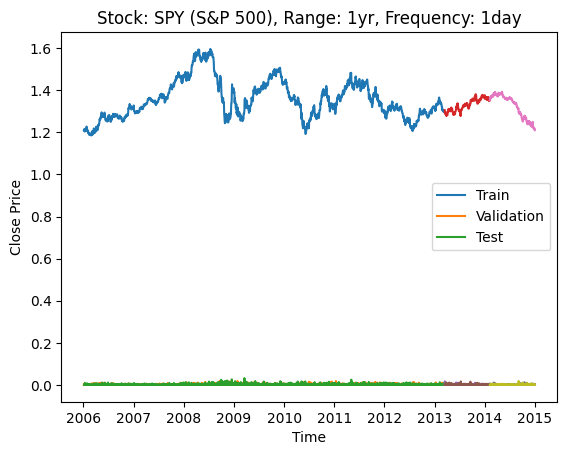

In [ ]:
dates_train, dates_val, dates_test = traintestsplit(date, val_size=0.1, test_size=0.1)
X_train, X_val, X_test = traintestsplit(X, val_size=0.1, test_size=0.1)
y_train, y_val, y_test = traintestsplit(y, val_size=0.1, test_size=0.1)

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])
plt.ylabel('Close Price')
plt.xlabel('Time')
plt.title('Stock: SPY (S&P 500), Range: 1yr, Frequency: 1day')

In [ ]:
print(dates_train.shape)
print(dates_val.shape)
print(dates_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2626,)
(328,)
(329,)
(2626, 3)
(328, 3)
(329, 3)
(2626, 3, 3)
(328, 3, 3)
(329, 3, 3)


In [ ]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.summary()

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50)

In [ ]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.xticks(rotation=45)
plt.legend(['Training Predictions', 'Training Observations'])

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.xticks(rotation=45)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.xticks(rotation=45)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

##### LSTM (univariate) pipeline

In [29]:
def LSTM_pipeline(df, window_size):
    train_predictions_df, val_predictions_df, test_predictions_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    date, X, y = df_to_windowed_df(df, window_size)
    dates_train, dates_val, dates_test = traintestsplit(date, val_size=0.1, test_size=0.1)
    X_train, X_val, X_test = traintestsplit(X, val_size=0.1, test_size=0.1)
    y_train, y_val, y_test = traintestsplit(y, val_size=0.1, test_size=0.1)

    for i, col in enumerate(df.columns):
        print('progress!')
        model = LSTM_tuning(X_train[:,:,i], y_train[:,i], X_val[:,:,i], y_val[:,i])

        train_predictions = iterative_forecasting(model, X_train[:,:,i])
        train_predictions_t = pd.DataFrame(train_predictions)
        train_predictions_df = pd.concat([train_predictions_df, train_predictions_t], axis=1)

        val_predictions = iterative_forecasting(model, X_val[:,:,i])
        val_predictions_t = pd.DataFrame(val_predictions)
        val_predictions_df = pd.concat([val_predictions_df, val_predictions_t], axis=1)

        test_predictions = iterative_forecasting(model, X_test[:,:,i])
        test_predictions_t = pd.DataFrame(test_predictions)
        test_predictions_df = pd.concat([test_predictions_df, test_predictions_t], axis=1)

    if len(df.columns) == 1:
        y_test_df, y_val_df, y_train_df = pd.DataFrame(y_test), pd.DataFrame(y_val), pd.DataFrame(y_train)
        y_test_df.columns, y_val_df.columns, y_train_df.columns, train_predictions_df.columns, val_predictions_df.columns, test_predictions_df.columns, = df.columns,df.columns,df.columns,df.columns,df.columns,df.columns
        performance(y_test_df, test_predictions_df)
        plot_LSTM(dates_train, dates_val, dates_test, train_predictions_df, val_predictions_df, test_predictions_df, y_train_df, y_val_df, y_test_df, df.columns.copy().tolist()[0])
        # test_predictions_df.to_csv(base_path + '/save_forecasts/spy_sp_lstm_forecasted.csv', index=False)
    else:
        y_train_df = y_train
        y_val_df = y_val
        y_test_ = math_coherence(y_test)
        full_train_predictions = train_predictions_df
        full_val_predictions = val_predictions_df
        print(test_predictions_df)
        print(test_predictions_df.shape)
        print(y_test_.shape)
        full_test_predictions = math_coherence(test_predictions_df)
        print(full_test_predictions)

        truncation = len(y_test_) // 5 * 5
        y_test_df = y_test_.iloc[:truncation,:]
        dates_test_df = dates_test[:truncation]
        print(y_test_df.shape)
        print(dates_test_df.shape)

        for true, forecast in zip([y_test_df],[full_test_predictions]):
            true['min'] = (true['Q1'] - (1.5*(true['Q3'] - true['Q1'])))
            true['max'] = (true['Q3'] + (1.5*(true['Q3'] - true['Q1'])))
            forecast['min'] = (forecast['Q1'] - (1.5*(forecast['Q3'] - forecast['Q1'])))
            forecast['max'] = (forecast['Q3'] + (1.5*(forecast['Q3'] - forecast['Q1'])))

        performance(y_test_df, full_test_predictions)

        for col in y_test_df.columns:
            plot_LSTM(dates_test_df, full_test_predictions[col], y_test_df[col], col)

        # plt.plot(dates_train, full_train_predictions, color='magenta', label = 'Training Predictions')
        # plt.plot(dates_train, y_train_df, color='red', label='Training Observations')
        # plt.plot(dates_val, full_val_predictions, color='peachpuff', label='Validation Predictions')
        # plt.plot(dates_val, y_val_df, color='lightblue', label='Validation Observations')
        plt.plot(dates_test_df, y_test_df, color='orange', label='Testing Observations')
        plt.plot(dates_test_df, full_test_predictions, color='green', label='Testing Predictions')

        # Create a custom legend
        orange_line = mlines.Line2D([], [], color='orange', markersize=15, label='Testing Observations')
        green_line = mlines.Line2D([], [], color='green', markersize=15, label='Testing Predictions')
        # lightblue_line = mlines.Line2D([], [], color='lightblue', markersize=15, label='Validation Observations')
        # peachpuff_line = mlines.Line2D([], [], color='peachpuff', markersize=15, label='Validation Predictions')
        # red_line = mlines.Line2D([], [], color='red', markersize=15, label='Training Observations')
        # magenta_line = mlines.Line2D([], [], color='magenta', markersize=15, label='Training Predictions')
        plt.legend(handles=[orange_line, green_line])
        plt.xticks(rotation=45)
        plt.title('All symbolic rates')
        # plt.grid(True)
        plt.show()

        # full_test_predictions.to_csv(base_path + '/save_forecasts/spy_lstm_forecasted.csv', index=False)

progress!


Best Hyperparameters:
batch_size: 120
dropout_rate: 0.13963868199206833
learn_rate: 0.0018898545722164754
neurons: 128
(2626, 3)
(328, 3)
(329, 3)
progress!


Best Hyperparameters:
batch_size: 86
dropout_rate: 0.2608221730080746
learn_rate: 0.0012628951946040106
neurons: 64
(2626, 3)
(328, 3)
(329, 3)
progress!


Best Hyperparameters:
batch_size: 108
dropout_rate: 0.1020832439816903
learn_rate: 0.001012778184882822
neurons: 128
(2626, 3)
(328, 3)
(329, 3)
            0         0         0
0    1.349119  0.001343  0.001363
1    1.349489  0.001343  0.001363
2    1.348993  0.001343  0.001363
3    1.348051  0.001343  0.001363
4    1.347916  0.001343  0.001363
..        ...       ...       ...
320  1.237200  0.001343  0.001363
321  1.239511  0.001343  0.001363
322  1.244271  0.001343  0.001363
323  1.251669  0.001343  0.001363
324  1.255137  0.001343  0.001363

[325 rows x 3 columns]
(325, 3)
(329, 3)
           Q1        Q2        Q3
0    1.349119  1.350462  1.351825
1    1.349489  1.350832  1.352195
2    1.348993  1.350336  1.351699
3    1.348051  1.349394  1.350757
4    1.347916  1.349259  1.350623
..        ...       ...       ...
320  1.237200  1.238543  1.239906
321  1.239511  1.240853  1.242217
322  1.244271  1.245614  1.246977
323  1.251669  1.253012  1.254375
324  1.255137  1.256480  1.2578

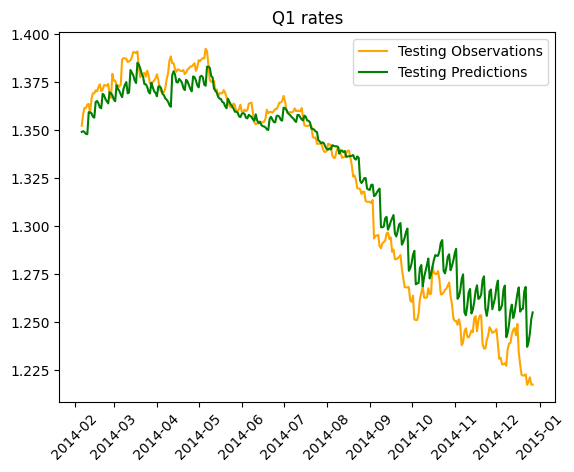

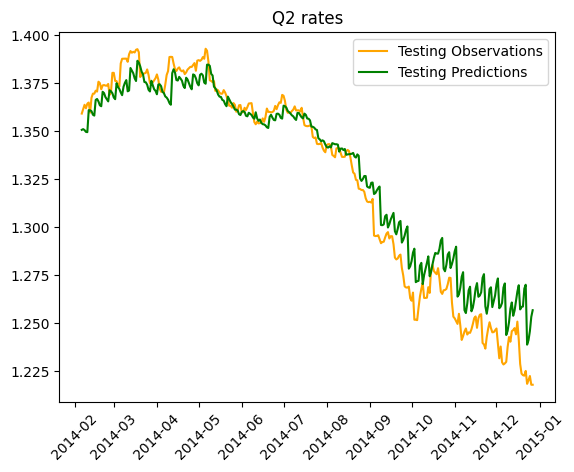

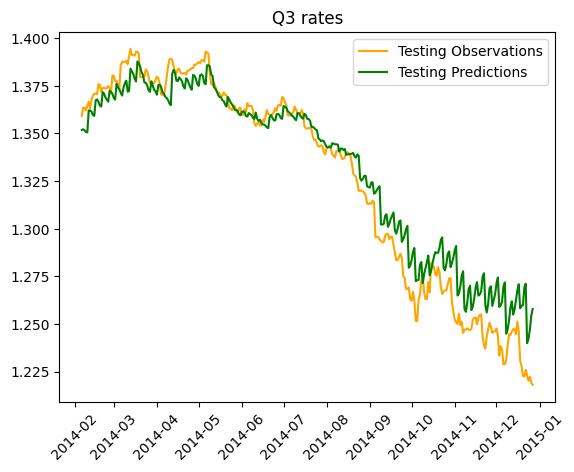

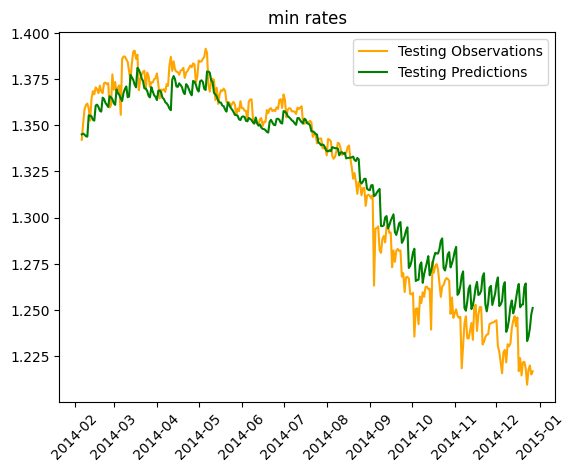

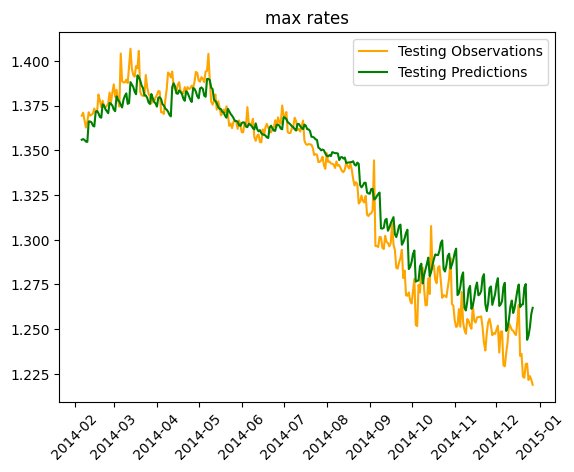

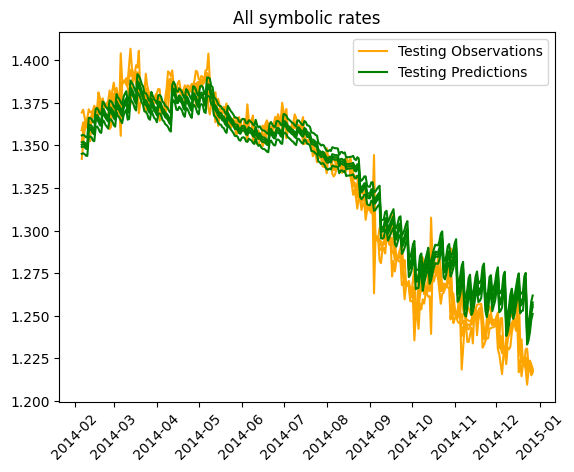

In [30]:
LSTM_pipeline(reyes_sym_data.copy(),window_size=3)

In [ ]:
forecast = pd.read_csv(base_path + '/save_forecasts/btc_vecm_forecasted.csv')
data = BTC_sym_data
train, test_df = traintestsplit(data, val_size=0, test_size=0.1)
test = math_coherence(test_df)
forecast.index = test.index
forecast.rename(columns={'q25':'Q1', 'q50':'Q2','q75':'Q3'}, inplace=True)

test['min'] = (test['Q1'] - (1.5*(test['Q3'] - test['Q1'])))
test['max'] = (test['Q3'] + (1.5*(test['Q3'] - test['Q1'])))
# forecast['min'] = (forecast['Q1'] - (1.5*(forecast['Q3'] - forecast['Q1'])))
# forecast['max'] = (forecast['Q3'] + (1.5*(forecast['Q3'] - forecast['Q1'])))
# print(forecast)
# print(test)

# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5,7))

# # Plotting 'min' columns for both test and forecast on the first subplot
# axes[0].plot(test.index, test['min'], color='orange', label='Testing Observations (min)')
# axes[0].plot(test.index, forecast['min'], color='green', label='Testing Predictions (min)')
# axes[0].legend(loc='upper left')
# axes[0].set_title('Min and Q3 Symbolic Prices')
# # axes[0].tick_params(axis='x', rotation=45)

# # Plotting 'Q3' columns for both test and forecast on the second subplot
# axes[1].plot(test.index, test['Q3'], color='orange', label='Testing Observations (Q3)')
# axes[1].plot(test.index, forecast['Q3'], color='green', label='Testing Predictions (Q3)')
# axes[1].legend(loc='upper left')
# # axes[1].set_title('Q3 Symbolic Prices')
# # axes[1].tick_params(axis='x', rotation=45)

# # Adjust the layout
# plt.tight_layout()
# plt.show()

# plt.plot(test.index, test[['min','Q3']], color='orange', label='Testing Observations')
# plt.plot(test.index, forecast[['min','Q3']], color='green', label='Testing Predictions')

# # Create a custom legend
# orange_line = mlines.Line2D([], [], color='orange', markersize=15, label='Testing Observations')
# green_line = mlines.Line2D([], [], color='green', markersize=15, label='Testing Predictions')
# plt.legend(handles=[orange_line, green_line])
# plt.xticks(rotation=45)
# plt.title('Min and Q3 symbolic prices')
# plt.show()

# Multivariate Forecasting

- VAR/VECM
- Check stationarity of individual series in multivariate series
- if all stationary, proceed with VAR.
- if some/all non-stationary, check for cointegration
- if no cointegration, convert to stationary as before and proceed with VAR.
- convert data to stationary using logarithm and differencing.
- revert predictions to the non-stationary scale using cumulative summation and exponential.
- if cointegration, proceed with VECM.

### VAR/VECM

In [ ]:
# temp = np.log(train.head(1))
# new_df = np.log(train).diff().dropna()
# new_df = pd.concat([temp, new_df])
# np.exp(new_df.cumsum())

In [43]:
data = reyes_sym_data.copy()

Text(0.5, 1.0, 'Stock: SPY (S&P 500), Range: 1yr, Frequency: 1day')

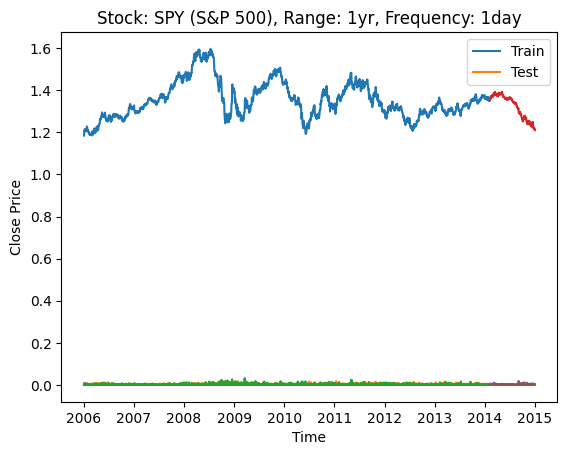

In [44]:
train, test = traintestsplit(data, val_size=0, test_size=0.1)

plt.plot(train.index, train)
plt.plot(test.index, test)
plt.legend(['Train', 'Test'])
plt.ylabel('Close Price')
plt.xlabel('Time')
plt.title('Stock: SPY (S&P 500), Range: 1yr, Frequency: 1day')

In [ ]:
train

q25     q50    q75
date                               
2010-01-04  113.1600  0.1000  0.050
2010-01-05  113.2600  0.0900  0.120
2010-01-06  113.6400  0.0800  0.070
2010-01-07  113.7800  0.1100  0.100
2010-01-08  114.0800  0.0300  0.040
...              ...     ...    ...
2013-08-01  170.2900  0.0700  0.190
2013-08-02  170.4000  0.1300  0.090
2013-08-05  170.6200  0.0600  0.090
2013-08-06  169.6900  0.0750  0.125
2013-08-07  168.8325  0.2575  0.110

[905 rows x 3 columns]

In [ ]:
# print("--CHECK STATIONARITY--")
# check_stationarity(train.close)
# check_stationarity(train['min'])
# check_stationarity(train['q25'])
# check_stationarity(train['q50'])
# check_stationarity(train['q75'])
# check_stationarity(train['max'])

In [ ]:
# Y = train['q25']
# X1 = train['q50']
# X2 = train['q75']

# # Combine the X series into a 2D array
# X = np.column_stack((X1, X2))

# # Add a constant to X
# X = sm.add_constant(X)

# # Estimate the model
# model = sm.OLS(Y, X)
# results = model.fit()

# # Print the coefficients
# print(results.params)
# # Engle-Granger test: apply results.resid to ADF test
# check_stationarity(results.resid)

# Johansen test
# Apply the Johansen cointegration test
johansen_test = vecm.coint_johansen(train, det_order=0, k_ar_diff=1)

# Print the eigenvalues
print('Eigenvalues:\n', johansen_test.lr1)

# Print the trace statistics
print('Trace Statistics:\n', johansen_test.lr2)

# Print the critical values
print('Critical Values (90%, 95%, 99%):\n', johansen_test.cvt)


Eigenvalues:
 [1.23072431e+03 4.32906980e+02 3.79030215e-01]
Trace Statistics:
 [7.97817328e+02 4.32527949e+02 3.79030215e-01]
Critical Values (90%, 95%, 99%):
 [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


### VAR

In [45]:
# temp = np.log(data).tail(1)
# stationary_data = np.log(data).diff().dropna()
# train, test = traintestsplit(stationary_data, val_size=0, test_size=0.1)

# stationary_data, test_stationary_data = train[1:].copy(), test.copy()
# temp = np.log(train).tail(1)
# stationary_data['q25'] = np.log(train['q25']).diff().dropna()
# temp_test = pd.concat([train['q25'].tail(1), test['q25']])
# test_stationary_data['q25'] = np.log(temp_test).diff().dropna()
# test_stationary_data

stationary_data, test_stationary_data = train.copy(), test.copy()
stationary_data['Q1'] = np.log(train['Q1'])
test_stationary_data['Q1'] = np.log(test['Q1'])

In [ ]:
# stationary_data, test_stationary_data = train[1:].copy(), test.copy()
# stationary_data['Q1'] = np.log(train['Q1']).diff().dropna()
# temp_test = np.log(pd.concat([train.tail(1), test])).diff().dropna()
# test_stationary_data['Q1'] = temp_test['Q1']

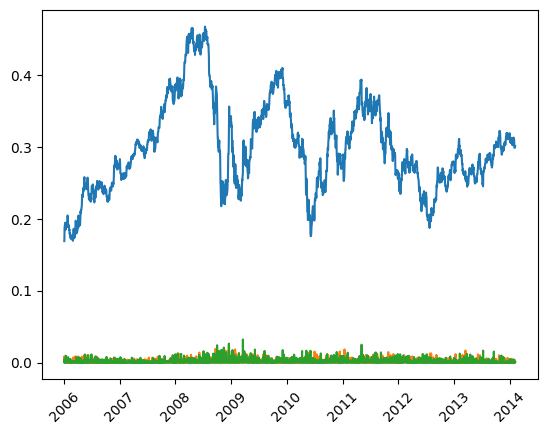

In [46]:
plt.plot(stationary_data)
plt.xticks(rotation=45)
plt.show()

In [47]:
var = VAR(stationary_data)

order = var.select_order()
order.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [48]:
# Fit the VAR model, returns the Estimation results
estimation_results = var.fit(7)
# Compute output summary of estimates
estimation_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 30, Aug, 2023
Time:                     06:03:15
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -35.0449
Nobs:                     2950.00    HQIC:                  -35.1307
Log likelihood:           39397.3    FPE:                5.27209e-16
AIC:                     -35.1789    Det(Omega_mle):     5.15587e-16
--------------------------------------------------------------------
Results for equation Q1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.000819         0.000407            2.012           0.044
L1.Q1         1.288048         0.020559           62.650           0.000
L1.Q2         0.624803         0.034658           18.028           0.000
L1.Q3         0.251730

In [49]:
# Fetch the lag order
lag_order = estimation_results.k_ar
print(lag_order)

# in-sample predictions
pred = estimation_results.fittedvalues
pred = pd.DataFrame(pred, index=train.index)
pred.columns = ['Q1', 'Q2', 'Q3']

# out-of-sample forecasts
forecasts = []
history = stationary_data.copy()

for t in range(0,len(test)-4,5):
    # Forecast one step ahead
    forecast = estimation_results.forecast(history.values[-lag_order:], 5)
    # Append the forecast to your list of forecasts
    forecasts.extend(forecast)
    # Append the actual observation from test set to your data (to be used for the next forecast)
    for i in range(5):
        history = pd.concat([history, pd.DataFrame([test_stationary_data.iloc[t+i,:]])])

forecasts = pd.DataFrame(forecasts, index=test.index[:len(forecasts)])
forecasts.columns = ['Q1', 'Q2', 'Q3']

forecasts['Q1'] = np.exp(forecasts['Q1'])
# temp_forecast = (pd.concat([np.log(train['Q1'].tail(1)), forecasts['Q1']])).cumsum()
# forecasts['Q1'] = np.exp(temp_forecast[1:])

# pred_df = math_coherence(pred)
forecast_df = math_coherence(forecasts)
train_df = math_coherence(train)
test_df = math_coherence(test)

test_df['min'] = (test_df['Q1'] - (1.5*(test_df['Q3'] - test_df['Q1'])))
test_df['max'] = (test_df['Q3'] + (1.5*(test_df['Q3'] - test_df['Q1'])))
forecast_df['min'] = (forecast_df['Q1'] - (1.5*(forecast_df['Q3'] - forecast_df['Q1'])))
forecast_df['max'] = (forecast_df['Q3'] + (1.5*(forecast_df['Q3'] - forecast_df['Q1'])))

7


In [ ]:
test_df

In [50]:
performance(test_df[:-4], forecast_df)
# forecast_df.to_csv(base_path + '/save_forecasts/eurusd_var_forecasted.csv', index=False)

Performance for column Q1:
	RMSE: 0.0071
	sMAPE: 0.1906
	MMRE: 0.3821
--------
Performance for column Q2:
	RMSE: 0.0074
	sMAPE: 0.1985
	MMRE: 0.398
--------
Performance for column Q3:
	RMSE: 0.0073
	sMAPE: 0.1993
	MMRE: 0.3996
--------
Performance for column min:
	RMSE: 0.0084
	sMAPE: 0.2318
	MMRE: 0.4648
--------
Performance for column max:
	RMSE: 0.0091
	sMAPE: 0.2641
	MMRE: 0.5296
--------
Overall Performance:
	Average RMSE: 0.0079
	Average sMAPE: 0.2169
	Average MMRE: 0.4348


In [52]:
new_test = test_df[:-4]

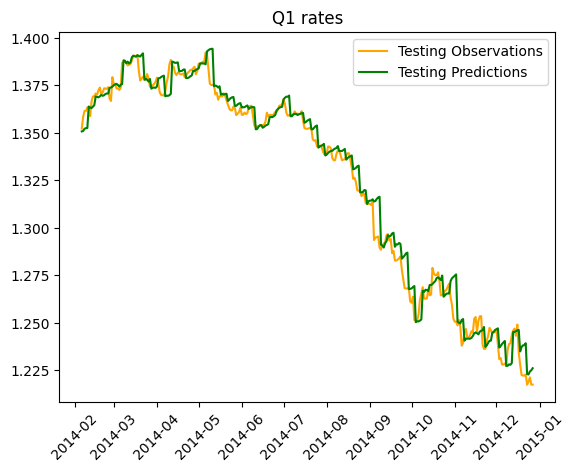

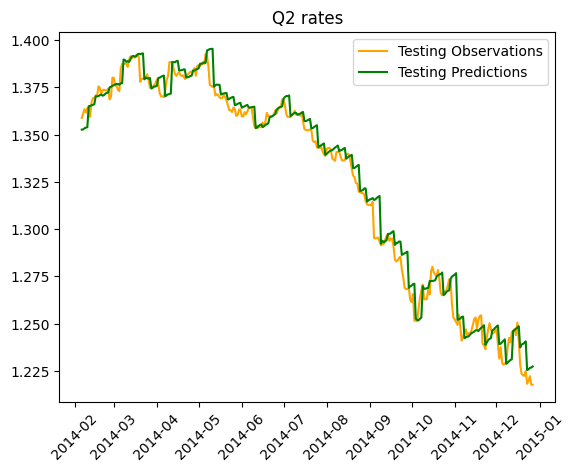

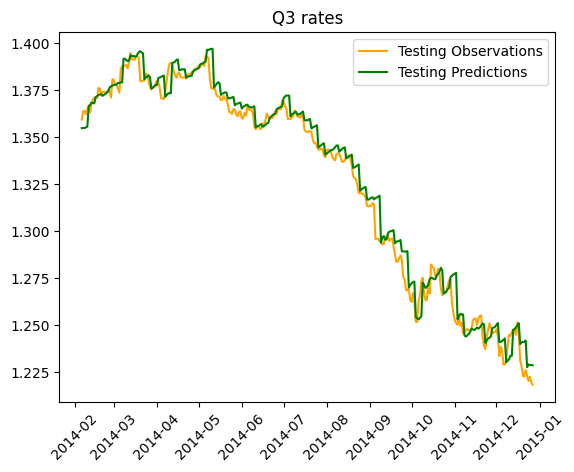

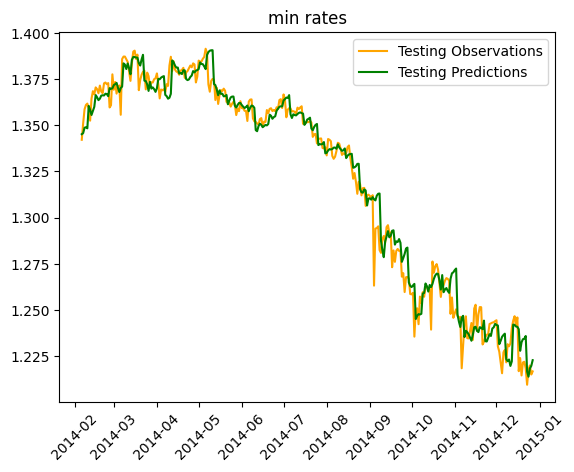

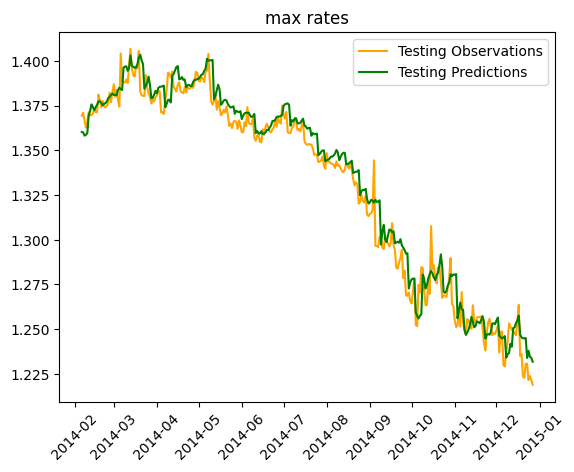

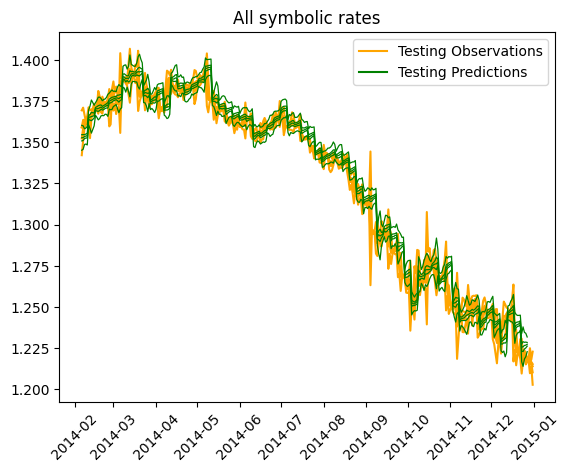

In [53]:
for col in test_df.columns:
    plt.plot(new_test.index, new_test[col], color='orange', label='Testing Observations')
    plt.plot(forecast_df.index, forecast_df[col], color='green', label='Testing Predictions')
    plt.xticks(rotation=45)
    orange_line = mlines.Line2D([], [], color='orange', markersize=15, label='Testing Observations')
    green_line = mlines.Line2D([], [], color='green', markersize=15, label='Testing Predictions')
    plt.legend(handles=[orange_line, green_line])
    plt.title(f'{col} rates')
    plt.show()

# plt.plot(train_df.index, train_df, color='lightblue', label='train')
plt.plot(test_df.index, test_df, color='orange', label='Testing Observations')
# plt.plot(pred_df.index, pred_df, color='peachpuff', label='in-sample prediction', lw=0.9)
plt.plot(forecast_df.index, forecast_df, color='green', label='Testing Predictions', lw=0.9)
plt.xticks(rotation=45)

# Create a custom legend
# lightblue_line = mlines.Line2D([], [], color='lightblue', markersize=15, label='train')
orange_line = mlines.Line2D([], [], color='orange', markersize=15, label='Testing Observations')
# peachpuff_line = mlines.Line2D([], [], color='peachpuff', markersize=15, label='in-sample prediction')
green_line = mlines.Line2D([], [], color='green', markersize=15, label='Testing Predictions')
plt.legend(handles=[orange_line, green_line])
plt.title('All symbolic rates')
plt.show()

### VECM

In [ ]:
model = var2(train)
results = model.select_order()
print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        40.01       40.02   2.375e+17       40.01
1        34.06       34.10   6.189e+14       34.07
2        33.99       34.07   5.805e+14       34.02
3        33.95      34.05*   5.539e+14       33.99
4        33.93       34.07   5.463e+14       33.98
5        33.91       34.07   5.323e+14       33.97
6        33.90       34.10   5.303e+14       33.98
7        33.90       34.12   5.272e+14       33.98
8        33.89       34.14   5.203e+14       33.98
9        33.86       34.14   5.075e+14       33.97
10       33.86       34.17   5.052e+14       33.97
11       33.85       34.19   5.020e+14       33.98
12       33.82       34.19   4.858e+14       33.96
13       33.79       34.20   4.748e+14       33.94
14       33.79       34.22   4.725e+14       33.95
15       33.76       34.23   4.607e+14       33.94
16       33.76       34.25   4.

In [ ]:
lag_order = 24
# coint_rank determined from johansen test: no. of cointegrated time series -1
model = vecm.VECM(train, k_ar_diff = lag_order, coint_rank = 2, deterministic="ci")
result = model.fit()
# result.summary()

# produce in-sample forecasts
pred = result.fittedvalues
pred = pd.DataFrame(pred, index=train.index[lag_order:-1])
pred.columns = ['Q1', 'Q2', 'Q3']
# out-of-sample forecasts
forecasts = []
history = train.copy()
history = history.values.tolist()

for t in range(len(test)):
    # Forecast one step ahead
    model = vecm.VECM(history, k_ar_diff = lag_order, coint_rank = 2, deterministic="ci")
    result = model.fit()
    # Forecast one step ahead
    forecast = result.predict(steps=1)
    # Append the forecast to your list of forecasts
    forecasts.append(forecast[0])
    # Append the actual observation from test set to your data (to be used for the next forecast)
    history.append(test.iloc[t,:])
    # history = pd.concat([history, pd.DataFrame([test.iloc[t,:]])])

# forecasts = result.predict(steps=len(test))

forecasts = pd.DataFrame(forecasts, index=test.index)
forecasts.columns = ['Q1', 'Q2', 'Q3']

pred_df = math_coherence(pred)
forecast_df = math_coherence(forecasts)
train_df = math_coherence(train)
test_df = math_coherence(test)

test_df['min'] = (test_df['Q1'] - (1.5*(test_df['Q3'] - test_df['Q1'])))
test_df['max'] = (test_df['Q3'] + (1.5*(test_df['Q3'] - test_df['Q1'])))
forecast_df['min'] = (forecast_df['Q1'] - (1.5*(forecast_df['Q3'] - forecast_df['Q1'])))
forecast_df['max'] = (forecast_df['Q3'] + (1.5*(forecast_df['Q3'] - forecast_df['Q1'])))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
training = train_df[lag_order:-1]
predictions = pred_df.copy()
training['min'] = (training['Q1'] - (1.5*(training['Q3'] - training['Q1'])))
training['max'] = (training['Q3'] + (1.5*(training['Q3'] - training['Q1'])))
predictions['min'] = (predictions['Q1'] - (1.5*(predictions['Q3'] - predictions['Q1'])))
predictions['max'] = (predictions['Q3'] + (1.5*(predictions['Q3'] - predictions['Q1'])))

performance(training, predictions)

Performance for column Q1:
	RMSE: 342.7019
	sMAPE: 0.8107
	MMRE: 0.0163
--------
Performance for column Q2:
	RMSE: 354.8873
	sMAPE: 0.8524
	MMRE: 0.0171
--------
Performance for column Q3:
	RMSE: 334.0127
	sMAPE: 0.7833
	MMRE: 0.0156
--------
Performance for column min:
	RMSE: 706.1768
	sMAPE: 1.6418
	MMRE: 0.0336
--------
Performance for column max:
	RMSE: 689.3222
	sMAPE: 1.4985
	MMRE: 0.0297
--------
Overall Performance:
	Average RMSE: 485.4202
	Average sMAPE: 1.1173
	Average MMRE: 0.0225


<ipython-input-74-7d9b04a7658f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['min'] = (training['Q1'] - (1.5*(training['Q3'] - training['Q1'])))
<ipython-input-74-7d9b04a7658f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['max'] = (training['Q3'] + (1.5*(training['Q3'] - training['Q1'])))


In [ ]:
performance(test_df, forecast_df)
# forecast_df.to_csv(base_path + '/save_forecasts/btc_vecm_forecasted.csv', index=False)

Performance for column q25:
	RMSE: 1634.056240941855
	sMAPE: 2.496952864445071
	MMRE: 0.012484764322225355
--------
Performance for column q50:
	RMSE: 1556.494597807042
	sMAPE: 2.359383417498658
	MMRE: 0.011796917087493291
--------
Performance for column q75:
	RMSE: 1538.1289224846537
	sMAPE: 2.3757748983421934
	MMRE: 0.011878874491710966
--------
Performance for column min:
	RMSE: 2309.78711666134
	sMAPE: 3.52244106401718
	MMRE: 0.017612205320085898
--------
Performance for column max:
	RMSE: 2029.265793035948
	sMAPE: 3.0800443616807054
	MMRE: 0.015400221808403527
--------
Overall Performance:
	Average RMSE: 1813.5465341861677
	Average sMAPE: 2.7669193211967618
	Average MMRE: 0.01383459660598381


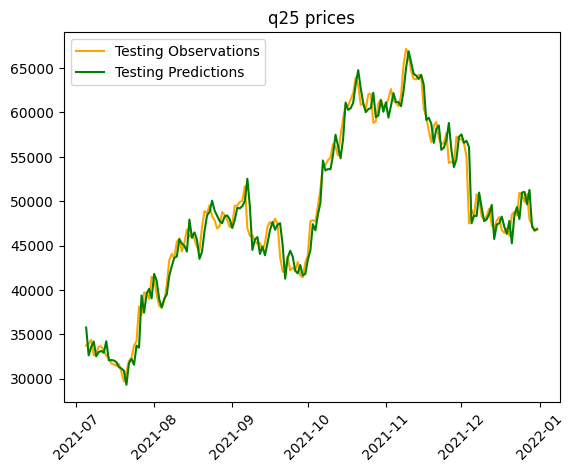

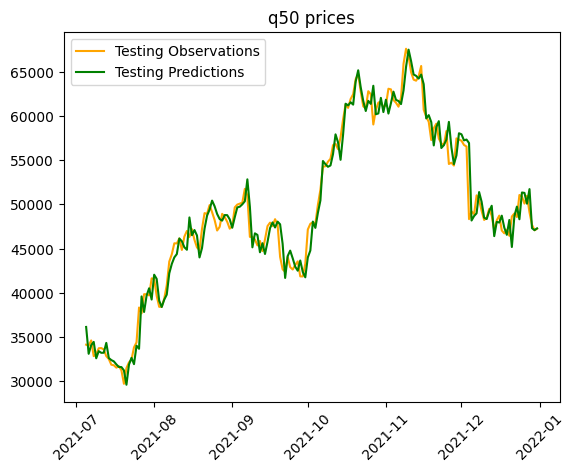

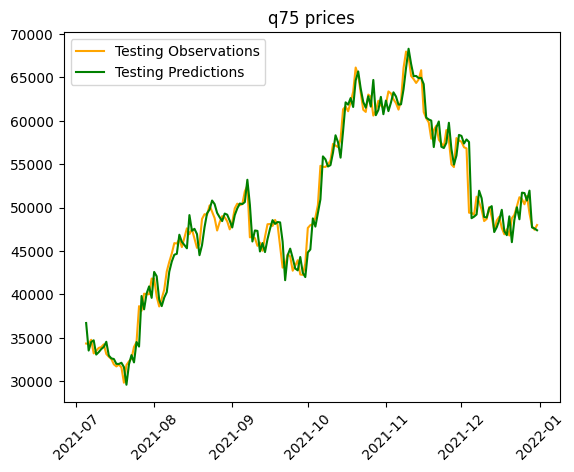

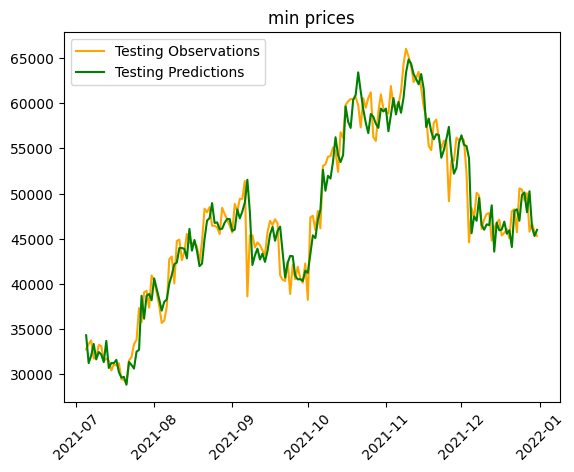

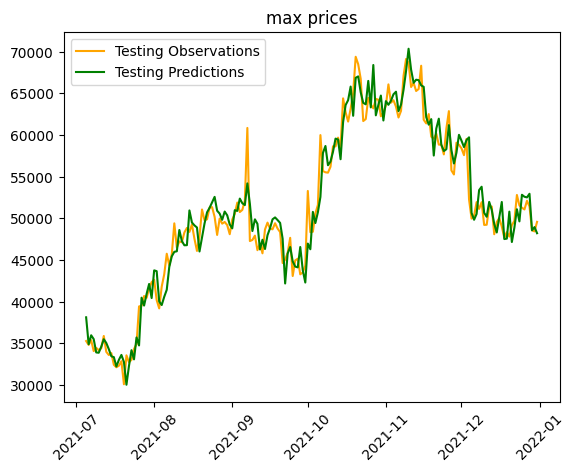

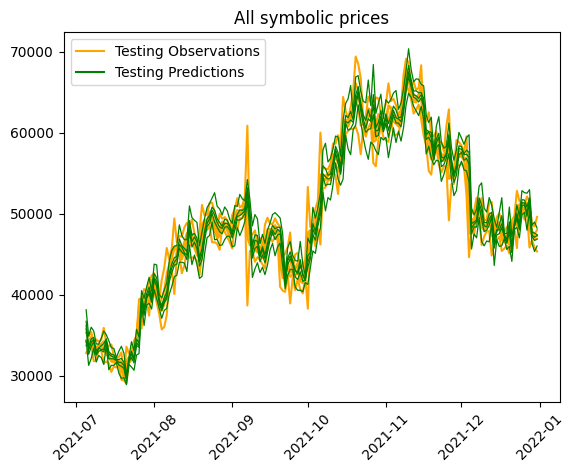

In [ ]:
for col in test_df.columns:
    plt.plot(test_df.index, test_df[col], color='orange', label='Testing Observations')
    plt.plot(forecast_df.index, forecast_df[col], color='green', label='Testing Predictions')
    plt.xticks(rotation=45)
    orange_line = mlines.Line2D([], [], color='orange', markersize=15, label='Testing Observations')
    green_line = mlines.Line2D([], [], color='green', markersize=15, label='Testing Predictions')
    plt.legend(handles=[orange_line, green_line])
    plt.title(f'{col} prices')
    plt.show()

# plt.plot(train_df.index, train_df, color='lightblue', label='train')
plt.plot(test_df.index, test_df, color='orange', label='Testing Observations')
# plt.plot(pred_df.index, pred_df, color='peachpuff', label='in-sample prediction', lw=0.9)
plt.plot(forecast_df.index, forecast_df, color='green', label='Testing Predictions', lw=0.9)
plt.xticks(rotation=45)

# Create a custom legend
# lightblue_line = mlines.Line2D([], [], color='lightblue', markersize=15, label='train')
orange_line = mlines.Line2D([], [], color='orange', markersize=15, label='Testing Observations')
# peachpuff_line = mlines.Line2D([], [], color='peachpuff', markersize=15, label='in-sample prediction')
green_line = mlines.Line2D([], [], color='green', markersize=15, label='Testing Predictions')
plt.legend(handles=[orange_line, green_line])
plt.title('All symbolic prices')
plt.show()

### LSTM

In [31]:
data = reyes_sym_data.copy()

In [32]:
def df_to_windowed_df(df, window_size):
    df = df.copy()
    windowed_data = []
    target_data = []
    date_data = df.index
    for i in range(window_size, len(df)):
        window = df.iloc[i-window_size:i]
        target = df.iloc[i]
        windowed_data.append(window)
        target_data.append(target)

    windowed_data, target_data = np.array(windowed_data), np.array(target_data)

    return date_data[window_size:], windowed_data, target_data

In [33]:
date, X, y = df_to_windowed_df(data, window_size=3)
X = np.reshape(X,(X.shape[0], X.shape[1], X.shape[2]))
print(X.shape)
print(y.shape)
print(date.shape)

(3283, 3, 3)
(3283, 3)
(3283,)


Text(0.5, 1.0, 'Stock: SPY (S&P 500), Range: 1yr, Frequency: 1day')

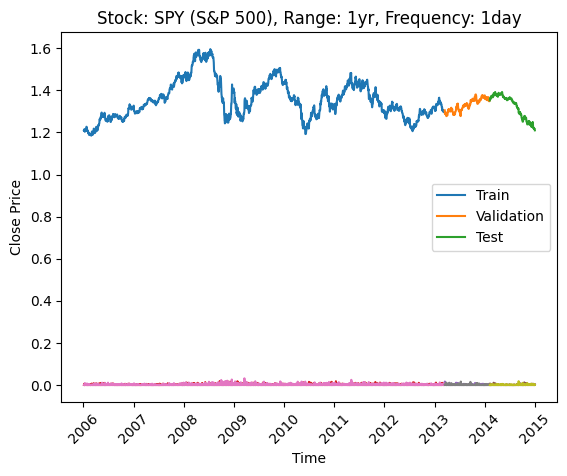

In [34]:
dates_train, dates_val, dates_test = traintestsplit(date, val_size=0.1, test_size=0.1)
X_train, X_val, X_test = traintestsplit(X, val_size=0.1, test_size=0.1)
y_train, y_val, y_test = traintestsplit(y, val_size=0.1, test_size=0.1)

# 0 = min variable... 4 = max variable
for i in range(3):
  plt.plot(dates_train, y_train[:,i])
  plt.plot(dates_val, y_val[:,i])
  plt.plot(dates_test, y_test[:,i])
  plt.xticks(rotation=45)

plt.legend(['Train', 'Validation', 'Test'])
plt.ylabel('Close Price')
plt.xlabel('Time')
plt.title('Stock: SPY (S&P 500), Range: 1yr, Frequency: 1day')

In [35]:
print(dates_train.shape)
print(dates_val.shape)
print(dates_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2626,)
(328,)
(329,)
(2626, 3)
(328, 3)
(329, 3)
(2626, 3, 3)
(328, 3, 3)
(329, 3, 3)


In [36]:
# Suppress TensorFlow logs
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Suppress Python warnings
warnings.filterwarnings('ignore')

def LSTM_tuning(X_train, y_train, X_val, y_val):
    np.random.seed(20)
    tf.random.set_seed(20)
    # Clear TensorFlow session
    K.clear_session()
    # Function to create model
    def create_model(learn_rate=0.001, neurons=32, dropout_rate=0, activation='relu'):
        # input layers
        inputs = Input(shape=(3,3))
        x = inputs
        x = LSTM(units=neurons, activation=activation, return_sequences=True)(x)
        # middle layer(s)
        x = Dropout(dropout_rate)(x)
        x = LSTM(units=neurons, activation=activation, return_sequences=False)(x)
        x = Dense(units=neurons, activation=activation)(x)
        # last layer
        outputs = Dense(3)(x)

        model = Model(inputs=inputs, outputs=outputs)

        optimizer = Adam(learning_rate=learn_rate)
        model.compile(loss='mean_squared_error', optimizer=optimizer)

        return model

    # Wrap Keras model with KerasRegressor
    model = KerasRegressor(build_fn=create_model, learn_rate=0.001, neurons=32, dropout_rate=0.0, activation='relu', verbose=0, epochs=50, batch_size=32)

    # Define the parameter space
    search_spaces = {
        'learn_rate': (0.001, 0.01, 'log-uniform'),  # log-uniform distribution
        'neurons': [32, 64, 128],  # list of choices
        'dropout_rate': (0.0, 0.5, 'uniform'),  # uniform distribution
        'batch_size': (32, 128, 'uniform'),  # uniform distribution
    }
    # Create TimeSeriesSplit object
    tscv = TimeSeriesSplit(n_splits=3)

    # Perform Bayesian Search Optimisation
    bayes = BayesSearchCV(estimator=model, search_spaces=search_spaces, n_iter=10, cv=tscv, n_jobs=-1, random_state=20)
    bayes_result = bayes.fit(X_train, y_train)

    best_params = bayes_result.best_params_
    # Build the model using best parameters
    best_model = create_model(learn_rate=best_params['learn_rate'],
                  neurons=best_params['neurons'],
                  dropout_rate=best_params['dropout_rate'])

    # Extract the best batch size from the best parameters
    best_batch_size = best_params['batch_size']

    # Define a ModelCheckpoint callback
    cp = ModelCheckpoint('best_model_m', monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    # Fit the best model
    best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=best_params['batch_size'], callbacks=[cp], verbose=0)

    # Load the best model
    best_model.load_weights('best_model_m')

    print("Best Hyperparameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")

    return best_model

def iterative_forecasting(model, X, steps=5):
    future_values = []
    print(X.shape)
    for i in range(0, len(X) - steps + 1, steps):
        input_sequence = X[i:i+1, :, :].copy()  # Take one sample from X
        for _ in range(steps):
            next_value = model.predict(input_sequence, verbose=0)
            future_values.append(next_value.flatten())
            input_sequence = np.roll(input_sequence, shift=-1, axis=1)
            input_sequence[0, -1, :] = next_value  # Assuming a univariate time series

    return np.array(future_values).reshape(-1,3)

In [37]:
model = LSTM_tuning(X_train, y_train, X_val, y_val)
# train_predictions = model.predict(X_train)
# train_predictions_df = math_coherence(train_predictions)
# y_train_df = math_coherence(y_train)
# plt.plot(dates_train, train_predictions_df, color='orange', label='Training Predictions')
# plt.plot(dates_train, y_train_df, color='blue', label='Training Observations')
# plt.xticks(rotation=45)
# # Create a custom legend
# blue_line = mlines.Line2D([], [], color='blue', markersize=15, label='Training Observations')
# orange_line = mlines.Line2D([], [], color='orange', markersize=15, label='Training Predictions')
# plt.legend(handles=[blue_line, orange_line])

Best Hyperparameters:
batch_size: 67
dropout_rate: 0.4229175301686692
learn_rate: 0.002723969965375165
neurons: 128


In [ ]:
# val_predictions = model.predict(X_val)

# val_predictions_df = math_coherence(val_predictions)
# y_val_df = math_coherence(y_val)

# plt.plot(dates_val, val_predictions_df, color='orange', label='Validation Predictions')
# plt.plot(dates_val, y_val_df, color='blue', label='Validation Observations')
# plt.xticks(rotation=45)
# # Create a custom legend
# blue_line = mlines.Line2D([], [], color='blue', markersize=15, label='Validation Observations')
# orange_line = mlines.Line2D([], [], color='orange', markersize=15, label='Validation Predictions')
# plt.legend(handles=[blue_line, orange_line])

11/11 [==============================] - 0s 21ms/step
Performance for column Q1:
	RMSE: 0.0072
	sMAPE: 0.1952
	MMRE: 0.3917
--------
Performance for column Q2:
	RMSE: 0.0071
	sMAPE: 0.1957
	MMRE: 0.3926
--------
Performance for column Q3:
	RMSE: 0.0066
	sMAPE: 0.1809
	MMRE: 0.3626
--------
Performance for column min:
	RMSE: 0.0098
	sMAPE: 0.2567
	MMRE: 0.516
--------
Performance for column max:
	RMSE: 0.0078
	sMAPE: 0.2119
	MMRE: 0.4237
--------
Overall Performance:
	Average RMSE: 0.0077
	Average sMAPE: 0.2081
	Average MMRE: 0.4173


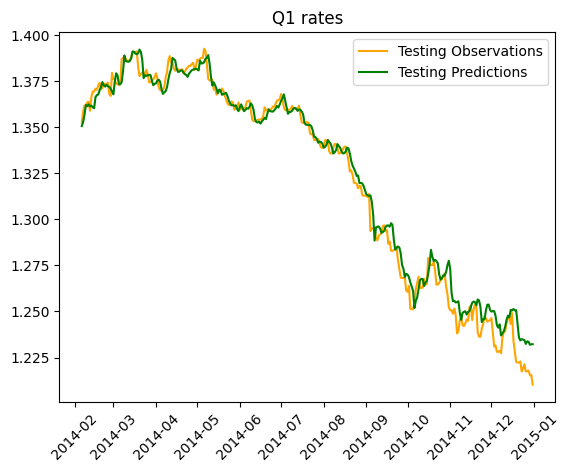

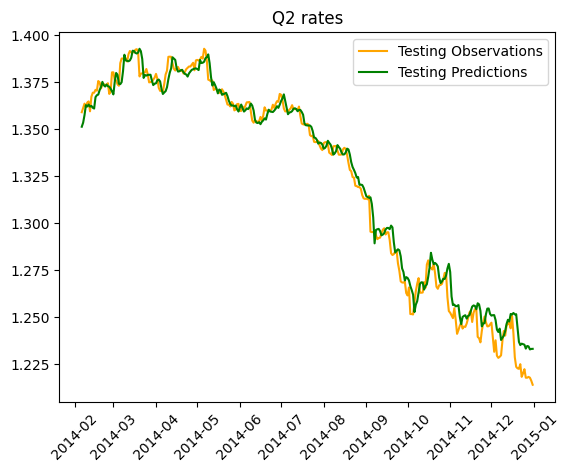

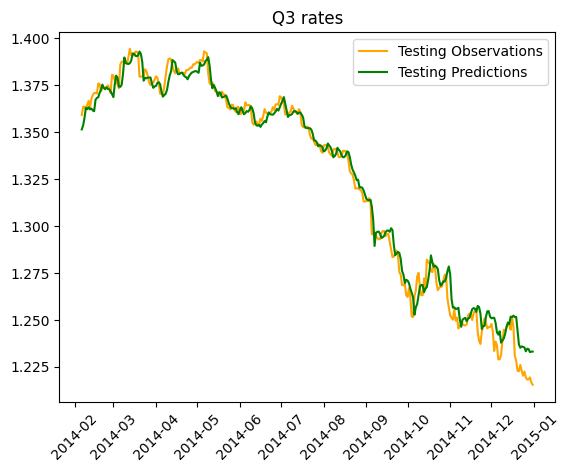

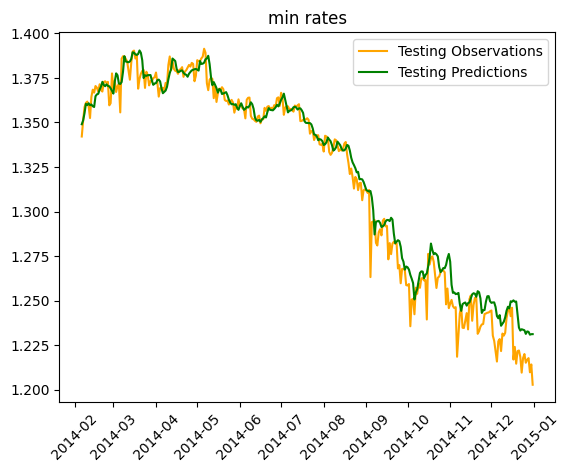

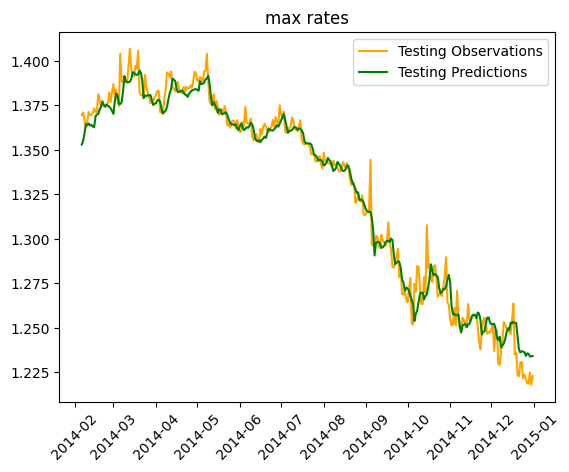

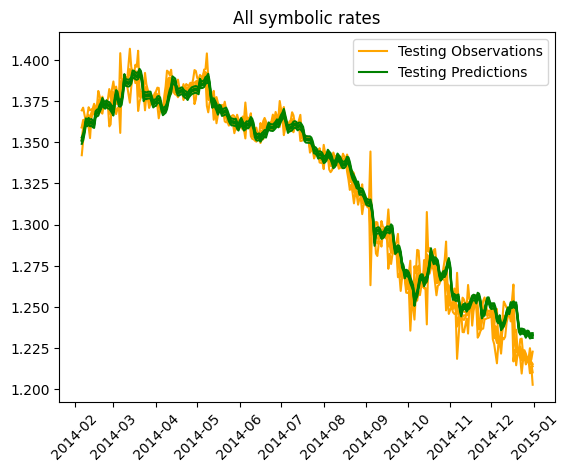

In [40]:
test_predictions = model.predict(X_test)
test_predictions_df = math_coherence(test_predictions)

y_test_df = math_coherence(y_test)

y_test_df['min'] = (y_test_df['Q1'] - (1.5*(y_test_df['Q3'] - y_test_df['Q1'])))
y_test_df['max'] = (y_test_df['Q3'] + (1.5*(y_test_df['Q3'] - y_test_df['Q1'])))
test_predictions_df['min'] = (test_predictions_df['Q1'] - (1.5*(test_predictions_df['Q3'] - test_predictions_df['Q1'])))
test_predictions_df['max'] = (test_predictions_df['Q3'] + (1.5*(test_predictions_df['Q3'] - test_predictions_df['Q1'])))

performance(y_test_df, test_predictions_df)

# test_predictions_df.to_csv(base_path + '/save_forecasts/eurusd_lstm_m_forecasted.csv', index=False)

for col in y_test_df.columns:
    plt.plot(dates_test, y_test_df[col], color='orange', label='Testing Observations')
    plt.plot(dates_test, test_predictions_df[col], color='green', label='Testing Predictions')
    plt.xticks(rotation=45)
    orange_line = mlines.Line2D([], [], color='orange', markersize=15, label='Testing Observations')
    green_line = mlines.Line2D([], [], color='green', markersize=15, label='Testing Predictions')
    plt.legend(handles=[orange_line, green_line])
    plt.title(f'{col} rates')
    plt.show()

plt.plot(dates_test, y_test_df, color='orange', label='Testing Observations')
plt.plot(dates_test, test_predictions_df, color='green', label='Testing Predictions')
plt.xticks(rotation=45)
# Create a custom legend
orange_line = mlines.Line2D([], [], color='orange', markersize=15, label='Testing Observations')
green_line = mlines.Line2D([], [], color='green', markersize=15, label='Testing Predictions')
plt.title('All symbolic rates')
plt.legend(handles=[orange_line, green_line])

In [ ]:
# plt.plot(dates_train, train_predictions_df, color='magenta', label = 'Training Predictions')
# plt.plot(dates_train, y_train_df, color='red', label='Training Observations')
# plt.plot(dates_val, val_predictions_df, color='peachpuff', label='Validation Predictions')
# plt.plot(dates_val, y_val_df, color='lightblue', label='Validation Observations')
# plt.plot(dates_test, test_predictions_df, color='orange', label='Testing Predictions')
# plt.plot(dates_test, y_test_df, color='blue', label='Testing Observations')

# # Create a custom legend
# blue_line = mlines.Line2D([], [], color='blue', markersize=15, label='Testing Observations')
# orange_line = mlines.Line2D([], [], color='orange', markersize=15, label='Testing Predictions')
# lightblue_line = mlines.Line2D([], [], color='lightblue', markersize=15, label='Validation Observations')
# peachpuff_line = mlines.Line2D([], [], color='peachpuff', markersize=15, label='Validation Predictions')
# red_line = mlines.Line2D([], [], color='red', markersize=15, label='Training Observations')
# magenta_line = mlines.Line2D([], [], color='magenta', markersize=15, label='Training Predictions')
# plt.legend(handles=[blue_line, orange_line, lightblue_line, peachpuff_line, red_line, magenta_line])

# Buy/Sell Trading Simulation

In [ ]:
def sym_trading_simulation(observed, forecasted):
    initial_capital = 10000
    # Lists to store timestamps of buy, sell, and hold actions
    buy_dates = []
    sell_dates = []
    hold_dates = []

    # Initialize variables
    capital = initial_capital
    asset_held = 0  # Number of units of the asset held
    num_buys = 0
    num_sells = 0

    # Iterate through the data values
    for date in range(1, len(forecasted)):  # Start from 1 because we need previous timestep's data
        # Buy conditions
        # Strong conditions
        if forecasted['min'].iloc[date] > observed['max'].iloc[date-1]:
            # Strong Buy
            asset_held += capital / observed['Q2'].iloc[date]
            capital = 0
            num_buys += 1
            buy_dates.append(forecasted.index[date])
        elif forecasted['max'].iloc[date] < observed['min'].iloc[date-1]:
            # Strong Sell
            capital += asset_held * observed['Q2'].iloc[date]
            asset_held = 0
            num_sells += 1
            sell_dates.append(forecasted.index[date])
        # Moderate-Strong conditions
        elif forecasted['min'].iloc[date] > observed['Q3'].iloc[date-1] or forecasted['Q1'].iloc[date] > observed['max'].iloc[date-1]:
            # Moderate-Strong Buy
            asset_held += (0.75 * capital) / observed['Q2'].iloc[date]
            capital *= 0.25
            num_buys += 1
            buy_dates.append(forecasted.index[date])
        elif forecasted['max'].iloc[date] < observed['Q1'].iloc[date-1] or forecasted['Q3'].iloc[date] < observed['min'].iloc[date-1]:
            # Moderate-Strong Sell
            capital += (0.75 * asset_held) * observed['Q2'].iloc[date]
            asset_held *= 0.25
            num_sells += 1
            sell_dates.append(forecasted.index[date])
        # Weak-Moderate conditions
        elif (forecasted['min'].iloc[date] > observed['Q2'].iloc[date-1] or
              forecasted['Q1'].iloc[date] > observed['Q3'].iloc[date-1] or
              forecasted['Q2'].iloc[date] > observed['max'].iloc[date-1]):
            # Weak-Moderate Buy
            asset_held += (0.50 * capital) / observed['Q2'].iloc[date]
            capital *= 0.50
            num_buys += 1
            buy_dates.append(forecasted.index[date])
        elif (forecasted['max'].iloc[date] < observed['Q2'].iloc[date-1] or
              forecasted['Q3'].iloc[date] < observed['Q1'].iloc[date-1] or
              forecasted['Q2'].iloc[date] < observed['min'].iloc[date-1]):
            # Weak-Moderate Sell
            capital += (0.50 * asset_held) * observed['Q2'].iloc[date]
            asset_held *= 0.50
            num_sells += 1
            sell_dates.append(forecasted.index[date])
        # Weak conditions
        elif (forecasted['min'].iloc[date] > observed['Q1'].iloc[date-1] or
              forecasted['Q1'].iloc[date] > observed['Q2'].iloc[date-1] or
              forecasted['Q2'].iloc[date] > observed['Q3'].iloc[date-1] or
              forecasted['Q3'].iloc[date] > observed['max'].iloc[date-1]):
            # Weak Buy
            asset_held += (0.25 * capital) / observed['Q2'].iloc[date]
            capital *= 0.75
            num_buys += 1
            buy_dates.append(forecasted.index[date])
        elif (forecasted['max'].iloc[date] < observed['Q3'].iloc[date-1] or
              forecasted['Q3'].iloc[date] < observed['Q2'].iloc[date-1] or
              forecasted['Q2'].iloc[date] < observed['Q1'].iloc[date-1] or
              forecasted['Q1'].iloc[date] < observed['min'].iloc[date-1]):
            # Weak Sell
            capital += (0.25 * asset_held) * observed['Q2'].iloc[date]
            asset_held *= 0.75
            num_sells += 1
            sell_dates.append(forecasted.index[date])
        else:
            # Hold
            hold_dates.append(forecasted.index[date])
    # If there's any asset left at the end, sell it
    capital += asset_held * observed['Q2'].iloc[-1]

    # Calculate final capital and profit or loss
    final_capital = capital
    profit_or_loss = final_capital - initial_capital

    # Plotting
    plt.figure(figsize=(10, 6))
    observed['Q2'].plot(label='Observed Median (Q2)', color='blue')
    forecasted['Q2'].plot(label='Forecasted Median (Q2)', color='orange')
    plt.fill_between(observed.index, observed['min'], observed['max'], color='cyan', alpha=0.3, label='Observed Min-Max range')
    plt.fill_between(forecasted.index, forecasted['min'], forecasted['max'], color='yellow', alpha=0.3, label='Forecasted Min-Max range')
    plt.scatter(buy_dates, forecasted['Q2'][buy_dates], marker='^', color='g', label='Buy Signal', alpha=1)
    plt.scatter(sell_dates, forecasted['Q2'][sell_dates], marker='v', color='r', label='Sell Signal', alpha=1)
    plt.scatter(hold_dates, forecasted['Q2'][hold_dates], marker='o', color='gray', label='Hold Signal', alpha=0.5, s=50)
    plt.legend()
    plt.title('Boxplot Aggregated Time Series Trading Simulation')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()

    return final_capital, profit_or_loss, num_buys, num_sells, buy_dates, sell_dates, hold_dates

def sp_trading_simulation(observed, forecasted):
    observed = pd.Series(observed)
    forecasted = pd.Series(forecasted)

    # Initialize variables
    initial_capital = 10000
    capital = initial_capital
    asset_held = 0  # Number of units of the asset held
    num_buys = 0
    num_sells = 0

    # Lists to store timestamps of buy, sell, and hold actions
    buy_dates = []
    sell_dates = []
    hold_dates = []

    # Iterate through the observed and forecasted values
    for date, (obs, forecast) in enumerate(zip(observed, forecasted)):
        if forecast > 1.01 * obs:  # Buy signal
            # Buy as much as possible
            asset_held += capital / obs
            capital = 0
            num_buys += 1
            buy_dates.append(observed.index[date])
        elif forecast < 0.99 * obs:  # Sell signal
            # Sell all assets
            capital += asset_held * obs
            asset_held = 0
            num_sells += 1
            sell_dates.append(observed.index[date])
        else:  # Hold
            hold_dates.append(observed.index[date])

    # If there's any asset left at the end, sell it
    capital += asset_held * (obs if len(observed) > 0 else 0)

    # Calculate final capital and profit or loss
    final_capital = capital
    profit_or_loss = final_capital - initial_capital

    # Plotting
    plt.figure(figsize=(10, 6))
    observed.plot(label='Observed', color='blue')
    forecasted.plot(label='Forecasted', color='orange')
    plt.scatter(buy_dates, forecasted[buy_dates], marker='^', color='g', label='Buy Signal', alpha=1)
    plt.scatter(sell_dates, forecasted[sell_dates], marker='v', color='r', label='Sell Signal', alpha=1)
    plt.scatter(hold_dates, forecasted[hold_dates], marker='o', color='gray', label='Hold Signal', alpha=0.5, s=50)
    plt.legend()
    plt.title('Mean-Aggregated Time Series Trading Simulation')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()

    return final_capital, profit_or_loss, num_buys, num_sells, buy_dates, sell_dates, hold_dates

def baseline(observed, forecasted):
    # Initial capital
    capital = 10000

    # Buy on the first date using all capital at Q2 price
    asset_held = capital / observed['Q2'].iloc[0]
    capital = 0  # Set capital to zero after the buy

    # Sell on the last date using all assets at Q2_end price
    Q2_end = observed['Q2'].iloc[-1]
    capital = asset_held * Q2_end
    asset_held = 0

    # Calculate profit or loss
    profit_or_loss = capital - 10000

    return capital, profit_or_loss

def baseline_sp(observed, forecasted):
    # Initial capital
    capital = 10000

    # Buy on the first date using all capital at Q2 price
    asset_held = capital / observed.iloc[0]
    capital = 0  # Set capital to zero after the buy

    # Sell on the last date using all assets at Q2_end price
    close_end = observed.iloc[-1]
    capital = asset_held * close_end
    asset_held = 0

    # Calculate profit or loss
    profit_or_loss = capital - 10000

    return capital, profit_or_loss

In [ ]:
forecast = pd.read_csv(base_path + '/save_forecasts/btc_arima_ms_forecasted.csv')
data = BTC_sym_data
train, test_df = traintestsplit(data, val_size=0, test_size=0.1)
test = math_coherence(test_df)

test['min'] = (test['Q1'] - (1.5*(test['Q3'] - test['Q1'])))
test['max'] = (test['Q3'] + (1.5*(test['Q3'] - test['Q1'])))
# forecast['min'] = (forecast['Q1'] - (1.5*(forecast['Q3'] - forecast['Q1'])))
# forecast['max'] = (forecast['Q3'] + (1.5*(forecast['Q3'] - forecast['Q1'])))
forecast.index = test.index
forecast.rename(columns={'q25':'Q1', 'q50':'Q2','q75':'Q3'}, inplace=True)
print(test)
print(forecast)

                    Q1         Q2          Q3          min          max
date                                                                   
2021-07-05  33718.1275  34146.640  34342.2225  32781.98500  35278.36500
2021-07-06  33917.9200  34032.845  34277.4125  33378.68125  34816.65125
2021-07-07  34367.4225  34627.075  34772.8425  33759.29250  35380.97250
2021-07-08  32628.1325  32853.970  33206.0600  31761.24125  34072.95125
2021-07-09  32860.9125  33053.830  33499.0575  31903.69500  34456.27500
...                ...        ...         ...          ...          ...
2021-12-27  50817.7975  50976.430  51332.2800  50046.07375  52104.00375
2021-12-28  47914.3975  49105.470  49319.7250  45806.40625  51427.71625
2021-12-29  47394.3950  47689.660  47861.2075  46694.17625  48561.42625
2021-12-30  46787.7375  47075.385  47444.9625  45801.90000  48430.80000
2021-12-31  46918.0900  47256.390  47980.9400  45323.81500  49575.21500

[180 rows x 5 columns]
                      Q1            Q2  

In [ ]:
forecast_sp = pd.read_csv(base_path + '/save_forecasts/btc_arima_sp_ms_forecasted.csv')
data_sp = BTC_sp_data
train_sp, test_sp = traintestsplit(data_sp, val_size=0, test_size=0.1)
forecast_sp.index = test_sp.index
print(test_sp)
print(forecast_sp)

                   close
date                    
2021-07-05  34102.246819
2021-07-06  34161.548868
2021-07-07  34562.720292
2021-07-08  32900.713993
2021-07-09  33177.991125
...                  ...
2021-12-27  51087.120868
2021-12-28  48869.489785
2021-12-29  47589.200319
2021-12-30  47107.995153
2021-12-31  47294.845972

[180 rows x 1 columns]
                   close
date                    
2021-07-05  35464.010456
2021-07-06  33794.106667
2021-07-07  34240.367886
2021-07-08  34640.898787
2021-07-09  32506.649279
...                  ...
2021-12-27  50049.864149
2021-12-28  51330.124758
2021-12-29  48317.650131
2021-12-30  47412.436712
2021-12-31  47034.413629

[180 rows x 1 columns]


In [ ]:
# Example usage:
final_capital, pnl = baseline(test, forecast)
print(f"Final Capital: ${final_capital:.2f}")
print(f"Profit/Loss: ${pnl:.2f}")

# Example usage:
final_capital_sp, pnl_sp = baseline_sp(test_sp, forecast_sp)
print(final_capital_sp)
print(pnl_sp)

Final Capital: $10846.82
Profit/Loss: $846.82
close    10856.70613
dtype: float64
close    856.70613
dtype: float64


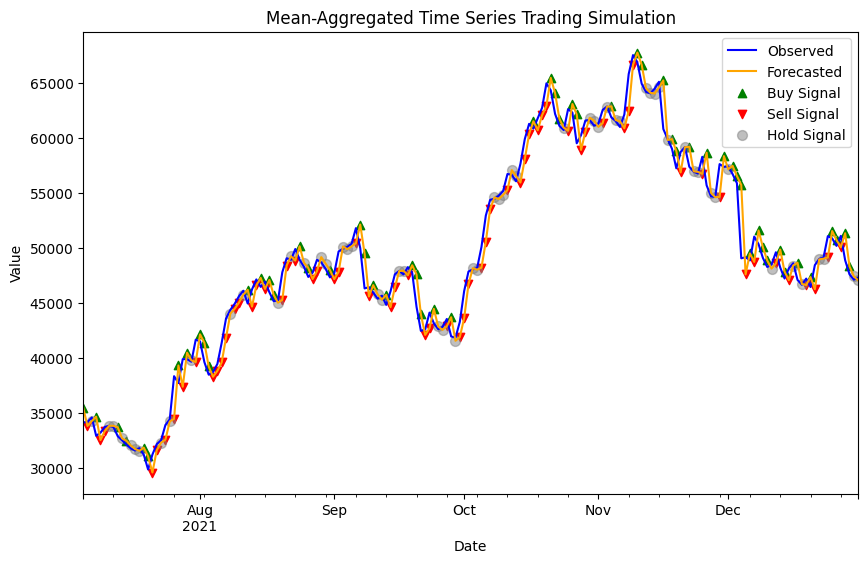

(7212.755824516162,
 -2787.2441754838383,
 57,
 64,
 [Timestamp('2021-07-05 00:00:00'),
  Timestamp('2021-07-08 00:00:00'),
  Timestamp('2021-07-13 00:00:00'),
  Timestamp('2021-07-15 00:00:00'),
  Timestamp('2021-07-19 00:00:00'),
  Timestamp('2021-07-20 00:00:00'),
  Timestamp('2021-07-27 00:00:00'),
  Timestamp('2021-07-29 00:00:00'),
  Timestamp('2021-08-01 00:00:00'),
  Timestamp('2021-08-02 00:00:00'),
  Timestamp('2021-08-03 00:00:00'),
  Timestamp('2021-08-12 00:00:00'),
  Timestamp('2021-08-15 00:00:00'),
  Timestamp('2021-08-17 00:00:00'),
  Timestamp('2021-08-18 00:00:00'),
  Timestamp('2021-08-24 00:00:00'),
  Timestamp('2021-08-26 00:00:00'),
  Timestamp('2021-08-31 00:00:00'),
  Timestamp('2021-09-07 00:00:00'),
  Timestamp('2021-09-08 00:00:00'),
  Timestamp('2021-09-10 00:00:00'),
  Timestamp('2021-09-13 00:00:00'),
  Timestamp('2021-09-19 00:00:00'),
  Timestamp('2021-09-20 00:00:00'),
  Timestamp('2021-09-21 00:00:00'),
  Timestamp('2021-09-24 00:00:00'),
  Timestamp(

In [ ]:
sp_trading_simulation(test_sp['close'], forecast_sp['close'])

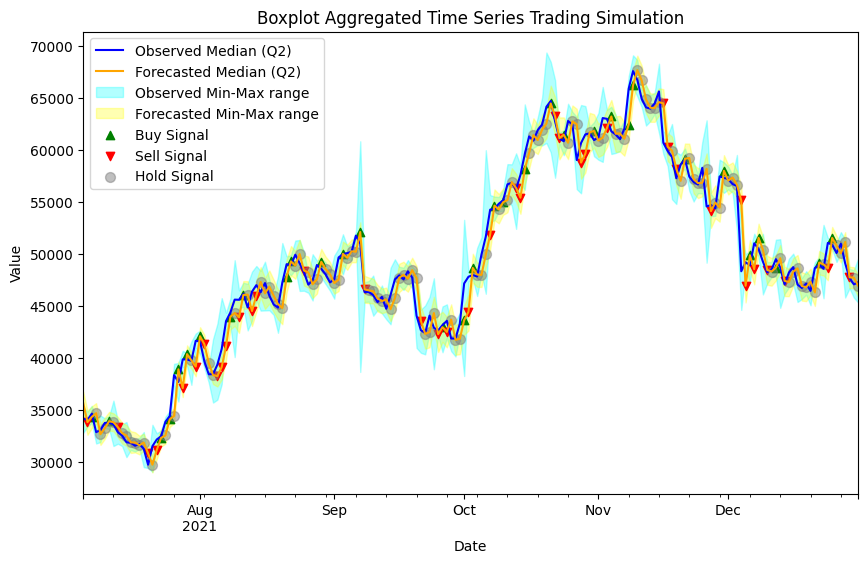

(10878.531352824879,
 878.5313528248789,
 33,
 38,
 [Timestamp('2021-07-07 00:00:00'),
  Timestamp('2021-07-11 00:00:00'),
  Timestamp('2021-07-23 00:00:00'),
  Timestamp('2021-07-25 00:00:00'),
  Timestamp('2021-07-27 00:00:00'),
  Timestamp('2021-07-29 00:00:00'),
  Timestamp('2021-08-01 00:00:00'),
  Timestamp('2021-08-08 00:00:00'),
  Timestamp('2021-08-11 00:00:00'),
  Timestamp('2021-08-21 00:00:00'),
  Timestamp('2021-08-22 00:00:00'),
  Timestamp('2021-08-29 00:00:00'),
  Timestamp('2021-09-03 00:00:00'),
  Timestamp('2021-09-07 00:00:00'),
  Timestamp('2021-09-26 00:00:00'),
  Timestamp('2021-10-01 00:00:00'),
  Timestamp('2021-10-03 00:00:00'),
  Timestamp('2021-10-08 00:00:00'),
  Timestamp('2021-10-10 00:00:00'),
  Timestamp('2021-10-15 00:00:00'),
  Timestamp('2021-10-21 00:00:00'),
  Timestamp('2021-10-24 00:00:00'),
  Timestamp('2021-10-31 00:00:00'),
  Timestamp('2021-11-04 00:00:00'),
  Timestamp('2021-11-08 00:00:00'),
  Timestamp('2021-11-09 00:00:00'),
  Timestamp('

In [ ]:
sym_trading_simulation(test, forecast)